<a href="https://colab.research.google.com/github/ancestor9/Gyeongbok-AI-study/blob/main/Titanic_Advanced_Feature_Engineering_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **[관련 링크](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook)**

### 관련 링크와는 약간 다르게 **Feature Engineering**

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

titanic_path = kagglehub.competition_download('titanic')

print('Data source import complete.')

Data source import complete.


## **0. Introduction**

I decided to write this kernel because **Titanic: Machine Learning from Disaster** is one of my favorite competitions on Kaggle. This is a beginner level kernel which focuses on **Exploratory Data Analysis** and **Feature Engineering**. A lot of people start Kaggle with this competition and they get lost in extremely long tutorial kernels. This is a short kernel compared to the other ones. I hope this will be a good guide for starters and inspire them with new feature engineering ideas.

**Titanic: Machine Learning from Disaster** is a great competition to apply domain knowledge for feature engineering, so I made a research and learned a lot about Titanic. There are many secrets to be revealed beneath the Titanic dataset. I tried to find out some of those secret factors that had affected the survival of passengers when the Titanic was sinking. I believe there are other features still waiting to be discovered.

This kernel has **3** main sections; **Exploratory Data Analysis**, **Feature Engineering** and **Model**, and it can achieve top **2%** (**0.83732**) public leaderboard score with a tuned Random Forest Classifier. It takes 60 seconds to run whole notebook. If you have any idea that might improve this kernel, please be sure to comment, or fork and experiment as you like. If you didn't understand any part, feel free to ask.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

SEED = 42

* Training set has **891** rows and test set has **418** rows
* Training set have **12** features and test set have **11** features
* One extra feature in training set is `Survived` feature, which is the target variable

In [4]:
# prompt: train.csv 파일의 위치를 찾으려면

import os

# Assuming 'titanic_path' variable holds the downloaded directory
train_csv_path = os.path.join(titanic_path, 'train.csv')
test_csv_path = os.path.join(titanic_path, 'test.csv')

# Check if the file exists
if os.path.exists(train_csv_path):
    print(f"The path to train.csv is: {train_csv_path}")
    print(f"The path to train.csv is: {test_csv_path}")
else:
    print("train.csv not found in the specified directory.")

The path to train.csv is: /root/.cache/kagglehub/competitions/titanic/train.csv
The path to train.csv is: /root/.cache/kagglehub/competitions/titanic/test.csv


In [5]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv(train_csv_path)
df_test = pd.read_csv(test_csv_path)
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## **1. Exploratory Data Analysis**

### **1.1 Overview**
* `PassengerId` is the unique id of the row and it doesn't have any effect on target
* `Survived` is the target variable we are trying to predict (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* `Pclass` (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has **3** unique values (**1**,  **2 **or **3**):
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex` and `Age` are self-explanatory
* `SibSp` is the total number of the passengers' siblings and spouse
* `Parch` is the total number of the passengers' parents and children
* `Ticket` is the ticket number of the passenger
* `Fare` is the passenger fare
* `Cabin` is the cabin number of the passenger
* `Embarked` is port of embarkation and it is a categorical feature which has **3** unique values (**C**, **Q** or **S**):
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In [6]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
569,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
804,805,1,3,"Hedman, Mr. Oskar Arvid",male,27.0,0,0,347089,6.9750,NaN,S


In [7]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
26,918,1,"Ostby, Miss. Helene Ragnhild",female,22.0,0,1,113509,61.9792,B36,C
108,1000,3,"Willer, Mr. Aaron (Abi Weller"")""",male,NaN,0,0,3410,8.7125,NaN,S
147,1039,3,"Davies, Mr. Evan",male,22.0,0,0,SC/A4 23568,8.0500,NaN,S


### **1.2 Missing Values**
As seen from below, some columns have missing values. `display_missing` function shows the count of missing values in every column in both training and test set.
* Training set have missing values in `Age`, `Cabin` and `Embarked` columns
* Test set have missing values in `Age`, `Cabin` and `Fare` columns

It is convenient to work on concatenated training and test set while dealing with missing values, otherwise filled data may overfit to training or test set samples. The count of missing values in `Age`, `Embarked` and `Fare` are smaller compared to total sample, but roughly **80%** of the `Cabin` is missing. Missing values in `Age`, `Embarked` and `Fare` can be filled with descriptive statistical measures but that wouldn't work for `Cabin`.

In [8]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




## <font color='red'> **DIY(Do It Yourself)-EDA**

In [9]:
# prompt: df_test의 모든 컬럼을 index로 하고 해당되는 컬럼의 uniques, missing ratio, 10개의 값 등을 데이터프레임으로 만들어줘. 간단하게 반복문을 사용하지 말고. 코드는 5줄 이내올 만들어줘

import pandas as pd

def analyze_df(df):
    uniques = df.nunique()
    datatype = df.dtypes
    missing_ratios = df.isnull().sum() / len(df)
    top10_values = df.apply(lambda x: x.value_counts().index[:10].tolist() if x.dtype == 'object' else x.nlargest(10).tolist())
    return pd.DataFrame({'uniques': uniques, 'datatype': datatype, 'missing_ratio': missing_ratios, 'top10_values': top10_values})

analyze_df(df_train)

,uniques,datatype,missing_ratio,top10_values
PassengerId,891,int64,0.000000,"[891, 890, 889, 888, 887, 886, 885, 884, 883, ..."
Survived,2,int64,0.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
Pclass,3,int64,0.000000,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
Name,891,object,0.000000,"[Braund, Mr. Owen Harris, Boulos, Mr. Hanna, F..."
Sex,2,object,0.000000,"[male, female]"
Age,88,float64,0.198653,"[80.0, 74.0, 71.0, 71.0, 70.5, 70.0, 70.0, 66...."
SibSp,7,int64,0.000000,"[8, 8, 8, 8, 8, 8, 8, 5, 5, 5]"
Parch,7,int64,0.000000,"[6, 5, 5, 5, 5, 5, 4, 4, 4, 4]"
Ticket,681,object,0.000000,"[347082, CA. 2343, 1601, 3101295, CA 2144, 347..."
Fare,248,float64,0.000000,"[512.3292, 512.3292, 512.3292, 263.0, 263.0, 2..."


<Axes: >

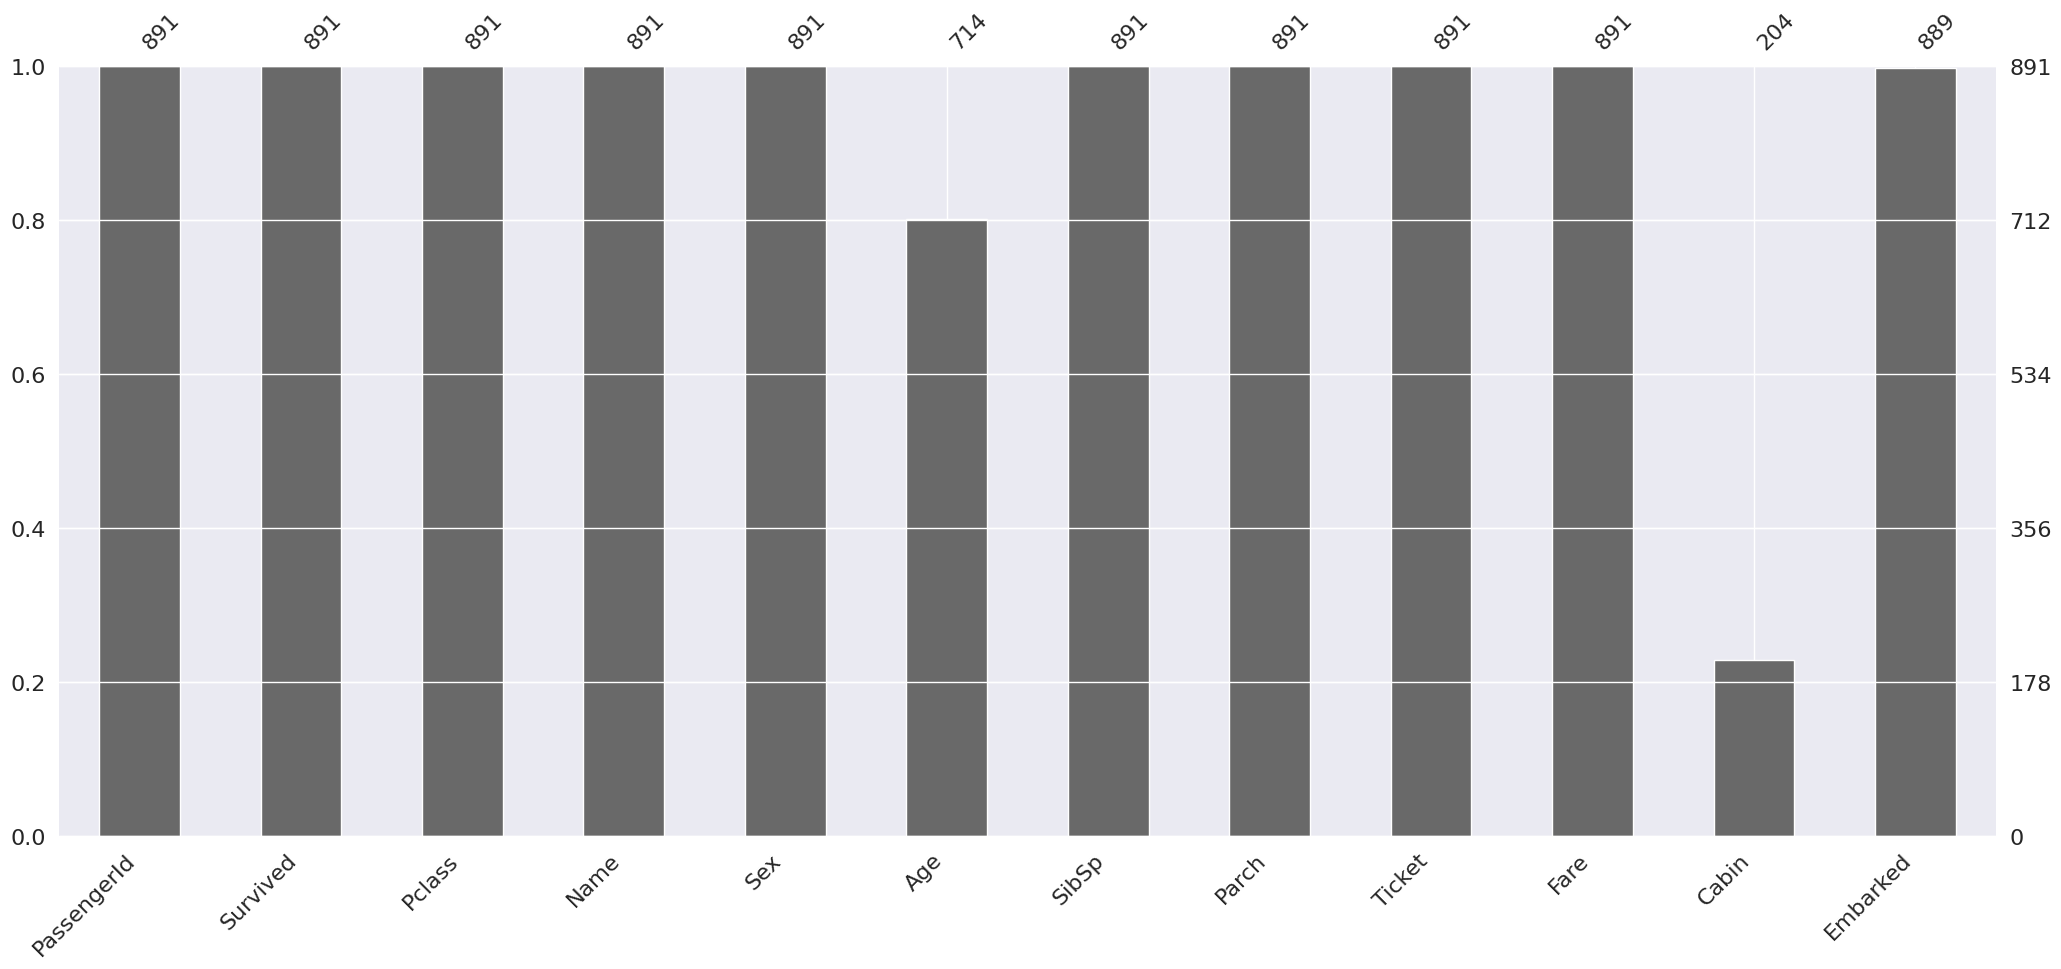

In [10]:
# prompt: missingno 모듈로 df_train을 시각화해줘

import missingno as msno

# Visualize missing values in df_train
msno.bar(df_train)
# plt.show()

<Axes: >

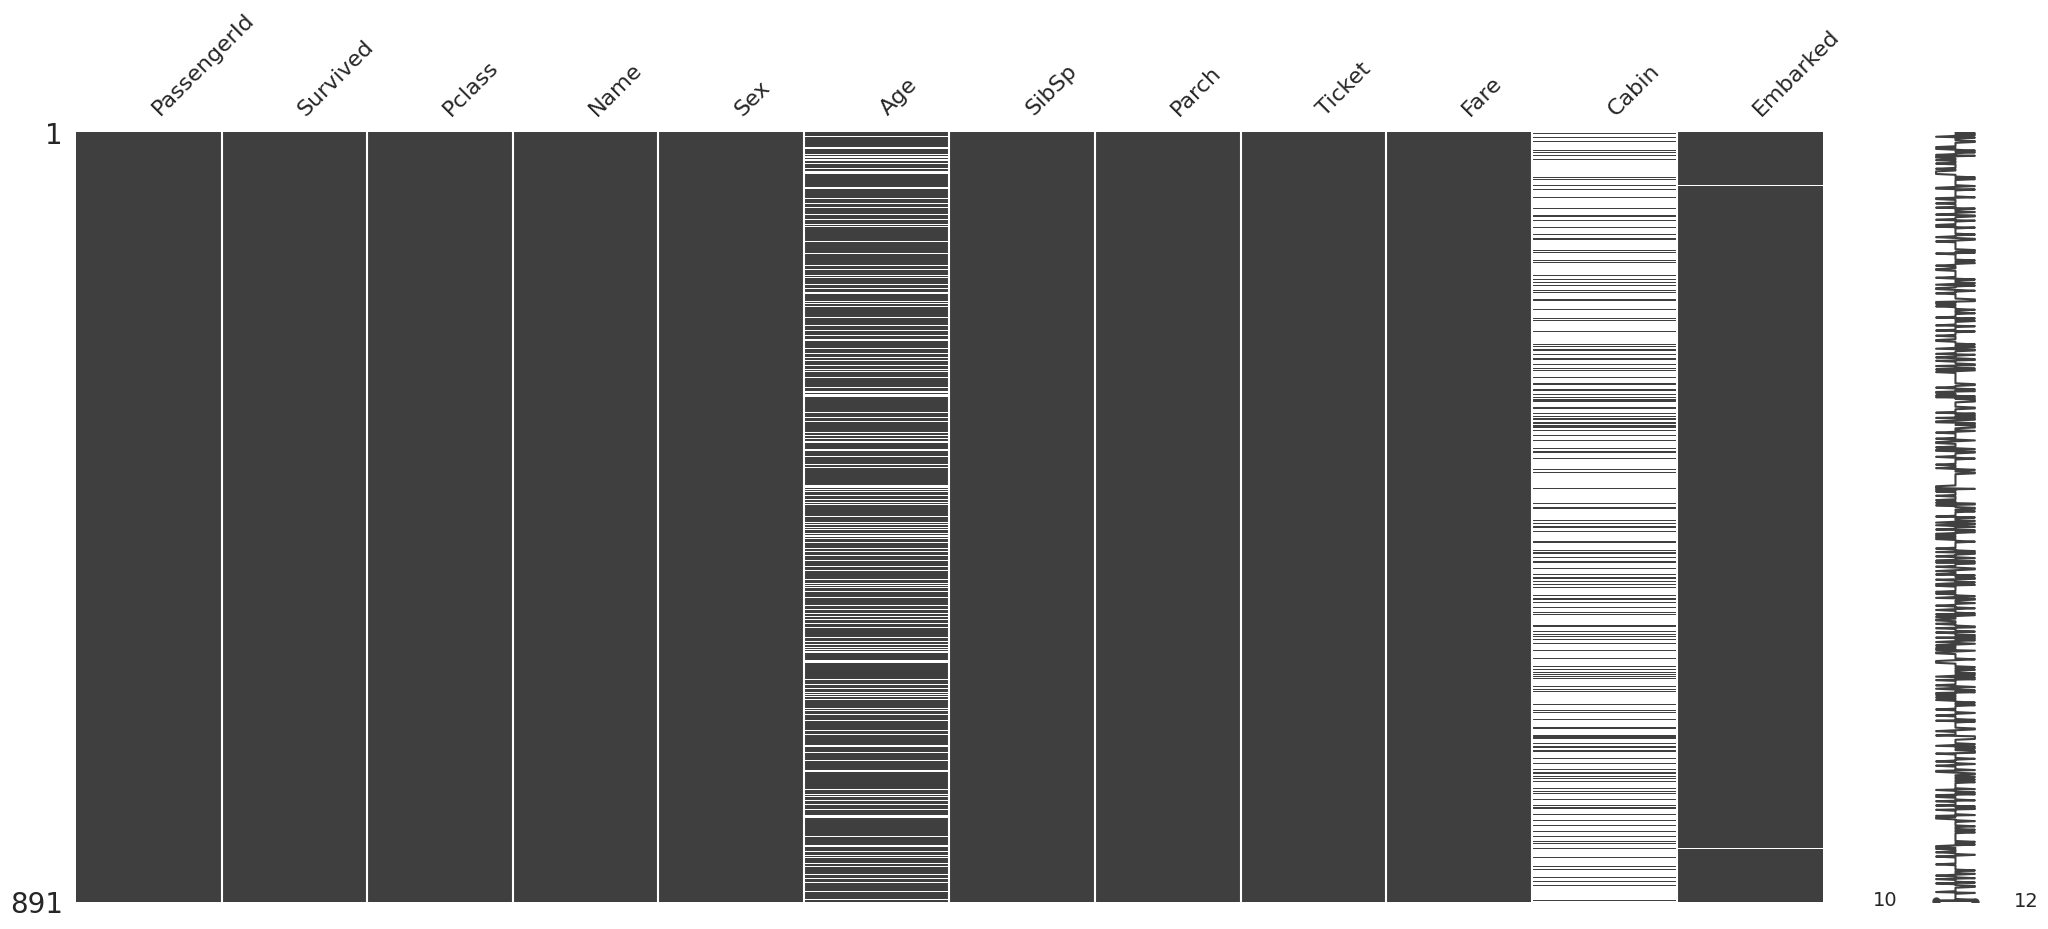

In [11]:
msno.matrix(df_train)
# 10은 결측 데이터가 발생한 최소 행의 인덱스 또는 행 번호를 의미하며, 12는 결측 데이터가 발생한 최대 행의 인덱스 또는 범위를 나타냅니다.

#### **1.2.1 Age**
Missing values in `Age` are filled with median age, but using median age of the whole data set is not a good choice. Median age of `Pclass` groups is the best choice because of its high correlation with `Age` **(0.408106)** and `Survived` **(0.338481)**. It is also more logical to group ages by passenger classes instead of other features.

In [12]:
df_all.corr()

ValueError: could not convert string to float: 'C85'

In [13]:
# prompt: 'C85'가 포함된 행을 나타내줘
df_train[df_train.apply(lambda row: row.astype(str).str.contains('C85').any(), axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [14]:
# prompt: df_train 컬럼의 값이 수치형인 컬럼만 추출하여 상관관계를 보여줘.  단 1줄로

df_train.select_dtypes(include=np.number).corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [15]:
numeric_features = df_all.select_dtypes(include=np.number).columns
df_all_corr = df_all[numeric_features].corr()
df_all_corr

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.178740,-0.150917,0.028814,-0.408106,-0.243699,-0.077221
Fare,0.178740,1.000000,0.221539,0.031428,-0.558629,0.160238,0.257307
Parch,-0.150917,0.221539,1.000000,0.008942,0.018322,0.373587,0.081629
PassengerId,0.028814,0.031428,0.008942,1.000000,-0.038354,-0.055224,-0.005007
Pclass,-0.408106,-0.558629,0.018322,-0.038354,1.000000,0.060832,-0.338481
SibSp,-0.243699,0.160238,0.373587,-0.055224,0.060832,1.000000,-0.035322
Survived,-0.077221,0.257307,0.081629,-0.005007,-0.338481,-0.035322,1.000000


In order to be more accurate, `Sex` feature is used as the second level of `groupby` while filling the missing `Age` values. As seen from below, `Pclass` and `Sex` groups have distinct median `Age` values. When passenger class increases, the median age for both males and females also increases. However, females tend to have slightly lower median `Age` than males. The median ages below are used for filling the missing values in `Age` feature.

In [16]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()
print(age_by_pclass_sex)

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64
Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [17]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].transform('median')

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all['Age'].fillna(age_by_pclass_sex)
df_all['Age'].isnull().sum()

0

In [18]:
analyze_df(df_all)

,uniques,datatype,missing_ratio,top10_values
Age,99,float64,0.000000,"[80.0, 76.0, 74.0, 71.0, 71.0, 70.5, 70.0, 70...."
Cabin,186,object,0.774637,"[C23 C25 C27, G6, B57 B59 B63 B66, C22 C26, F3..."
Embarked,3,object,0.001528,"[S, C, Q]"
Fare,281,float64,0.000764,"[512.3292, 512.3292, 512.3292, 512.3292, 263.0..."
Name,1307,object,0.000000,"[Connolly, Miss. Kate, Kelly, Mr. James, Braun..."
Parch,8,int64,0.000000,"[9, 9, 6, 6, 5, 5, 5, 5, 5, 5]"
PassengerId,1309,int64,0.000000,"[1309, 1308, 1307, 1306, 1305, 1304, 1303, 130..."
Pclass,3,int64,0.000000,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
Sex,2,object,0.000000,"[male, female]"
SibSp,7,int64,0.000000,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 5]"


#### **1.2.2 Embarked**
`Embarked` is a categorical feature and there are only **2** missing values in whole data set. Both of those passengers are female, upper class and they have the same ticket number. This means that they know each other and embarked from the same port together. The mode `Embarked` value for an upper class female passenger is **C (Cherbourg)**, but this doesn't necessarily mean that they embarked from that port.

In [19]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


When I googled **Stone, Mrs. George Nelson (Martha Evelyn)**, I found that she embarked from **S (Southampton)** with her maid **Amelie Icard**, in this page [Martha Evelyn Stone: Titanic Survivor](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

> *Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*

Missing values in `Embarked` are filled with **S** with this information.

In [20]:
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')
df_all['Embarked'].isnull().sum()

0

#### **1.2.3 Fare**
There is only one passenger with missing `Fare` value. We can assume that `Fare` is related to family size (`Parch` and `SibSp`) and `Pclass` features. Median `Fare` value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [21]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [22]:
df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()

Pclass  Parch  SibSp
1       0      0         31.33960
               1         75.25000
               2         51.47920
        1      0         63.35830
               1         83.15830
        2      0         83.15830
               1        120.00000
               2        262.37500
               3        263.00000
        3      1        262.37500
        4      1        263.00000
2       0      0         13.00000
               1         26.00000
               2         73.50000
               3         21.00000
        1      0         23.00000
               1         26.25000
               2         33.00000
        2      0         26.25000
               1         41.57920
        3      0         39.00000
               1         23.00000
               2         18.75000
3       0      0          7.85420
               1         14.45625
               2         19.83960
               3         16.92500
        1      0         12.47500
               1         15.24580
               2         19.25830
               3         22.02500
               4         34.40625
        2      0         15.24580
               1         22.01250
               2         34.37500
               3         27.90000
               4         31.27500
               5         46.90000
               8         69.55000
        3      0         19.25830
               1         34.37500
        4      0         23.27085
               1         27.90000
        5      0         34.40625
               1         31.33125
        6      1         46.90000
        9      1         69.55000
Name: Fare, dtype: float64

In [23]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
print('Median Fare of a male with a third class ticket and no family: {}'.format(med_fare))
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

Median Fare of a male with a third class ticket and no family: 7.8542


In [24]:
df_all['Fare'].isnull().sum()

0

#### **1.2.4 Cabin**
`Cabin` feature is little bit tricky and it needs further exploration. The large portion of the `Cabin` feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the `Cabin` values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.
![alt text](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)
* On the Boat Deck there were **6** rooms labeled as **T, U, W, X, Y, Z** but only the **T** cabin is present in the dataset
* **A**, **B** and **C** decks were only for 1st class passengers
* **D** and **E** decks were for all classes
* **F** and **G** decks were for both 2nd and 3rd class passengers
* From going **A** to **G**, distance to the staircase increases which might be a factor of survival

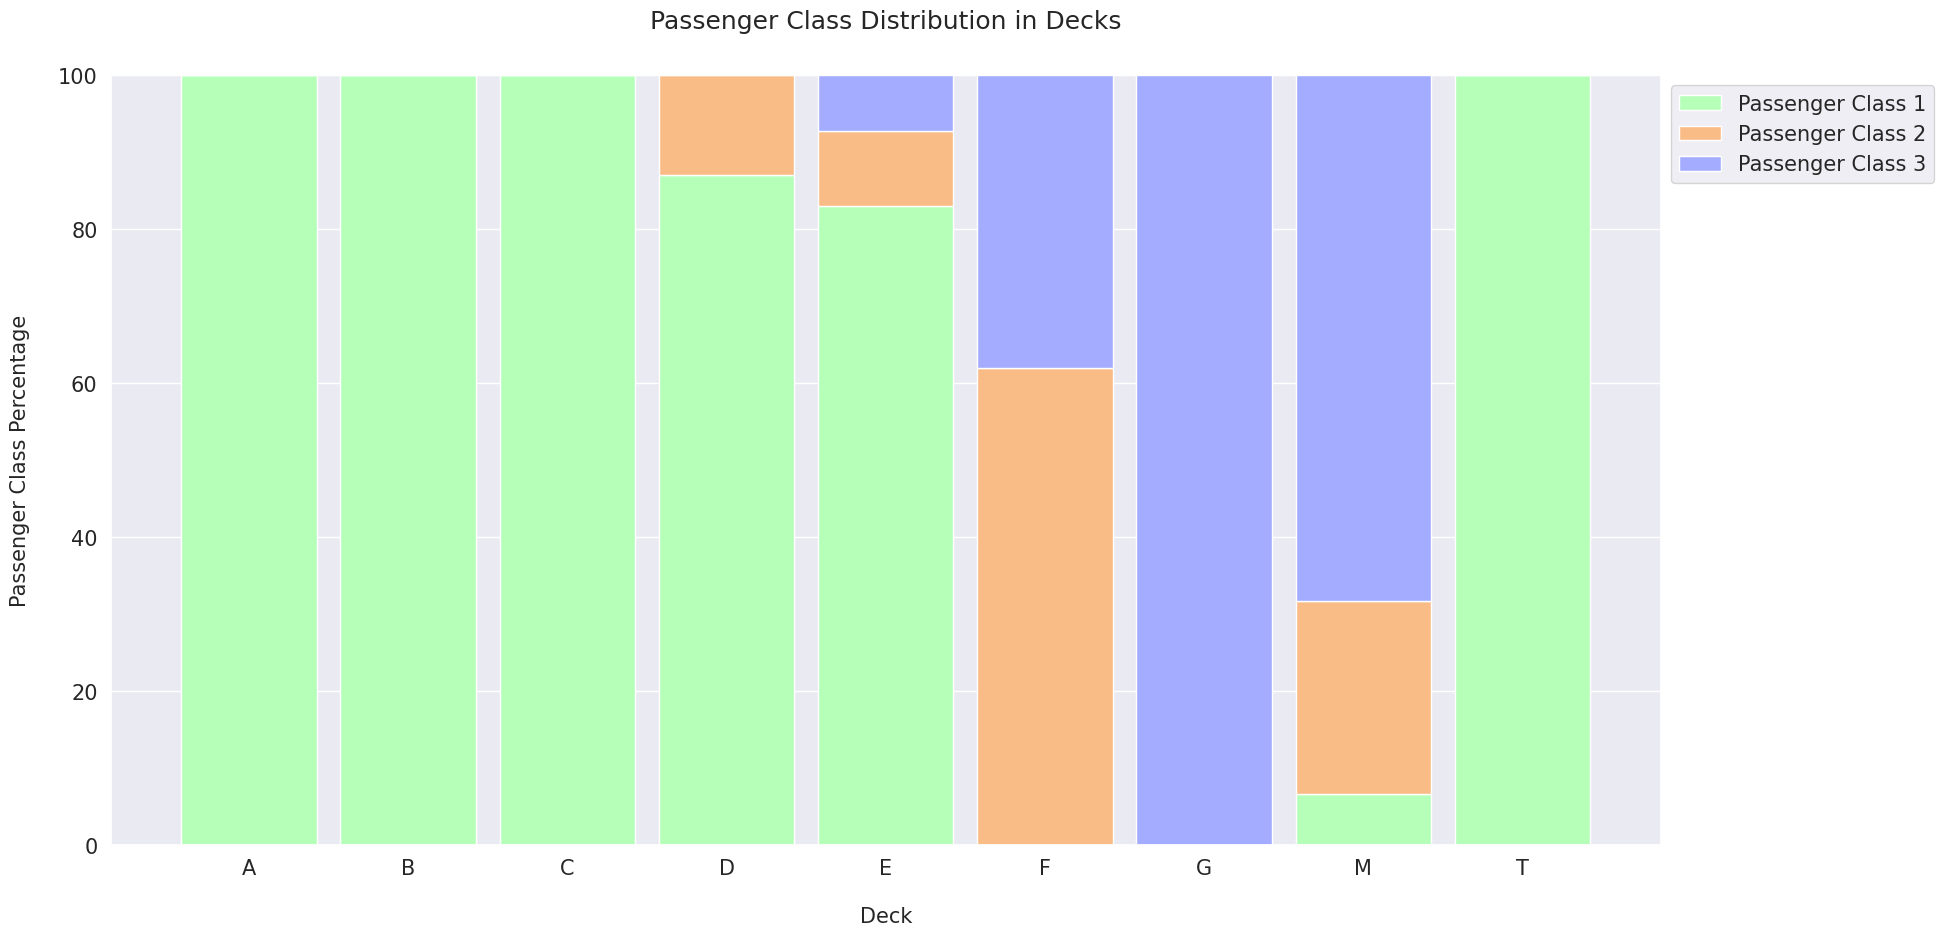

In [25]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch',
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):

    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]

    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):

    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)

    plt.show()

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

* **100%** of **A**, **B** and **C** decks are 1st class passengers
* Deck **D** has **87%** 1st class and **13%** 2nd class passengers
* Deck **E** has **83%** 1st class, **10%** 2nd class and **7%** 3rd class passengers
* Deck **F** has **62%** 2nd class and **38%** 3rd class passengers
* **100%** of **G** deck are 3rd class passengers
* There is one person on the boat deck in **T** cabin and he is a 1st class passenger. **T** cabin passenger has the closest resemblance to **A** deck passengers so he is grouped with **A** deck
* Passengers labeled as **M** are the missing values in `Cabin` feature. I don't think it is possible to find those passengers' real `Deck` so I decided to use **M** like a deck

In [26]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

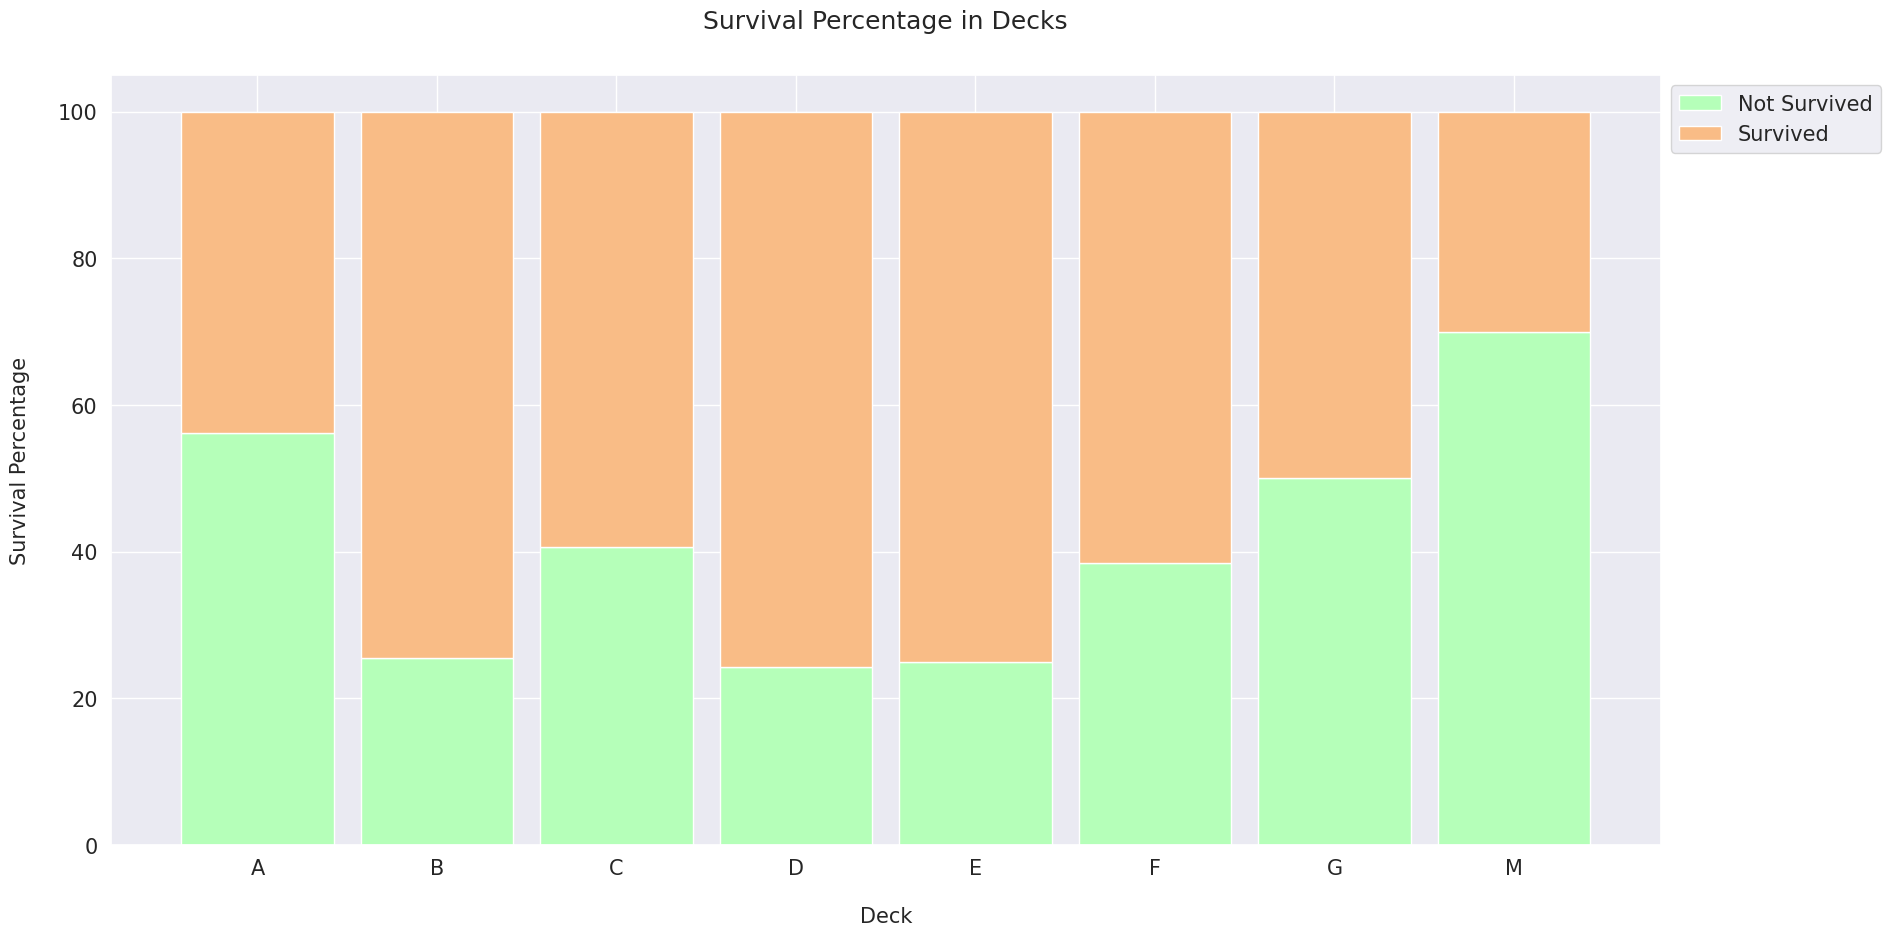

In [27]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):

    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]

    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

    return surv_counts, surv_percentages

def display_surv_dist(percentages):

    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)

    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

As I suspected, every deck has different survival rates and that information can't be discarded. Deck **B**, **C**, **D** and **E** have the highest survival rates. Those decks are mostly occupied by 1st class passengers. **M** has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers. To conclude, cabins used by 1st class passengers have higher survival rates than cabins used by 2nd and 3rd class passengers. In my opinion **M** (Missing `Cabin` values) has the lowest survival rate because they couldn't retrieve the cabin data of the victims. That's why I believe labeling that group as **M** is a reasonable way to handle the missing data. It is a unique group with shared characteristics. `Deck` feature has high-cardinality right now so some of the values are grouped with each other based on their similarities.
* **A**, **B** and **C** decks are labeled as **ABC** because all of them have only 1st class passengers
* **D** and **E** decks are labeled as **DE** because both of them have similar passenger class distribution and same survival rate
* **F** and **G** decks are labeled as **FG** because of the same reason above
* **M** deck doesn't need to be grouped with other decks because it is very different from others and has the lowest survival rate.

In [28]:
df_all['Deck'].value_counts()

,count
Deck,
M,1014
C,94
B,65
D,46
E,41
A,23
F,21
G,5


In [29]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

,count
Deck,
M,1014
ABC,182
DE,87
FG,26


In [30]:
df_all['Deck'].isnull().sum()

0

After filling the missing values in `Age`, `Embarked`, `Fare` and `Deck` features, there is no missing value left in both training and test set. `Cabin` is dropped because `Deck` feature is used instead of it.

In [31]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




In [32]:
df_train.isnull().sum().sum()

0

In [33]:
df_test.isnull().sum().sum()

0

In [34]:
df_all.isnull().sum().sum()

418

### **1.3 Target Distribution**
* **38.38%** (342/891) of training set is **Class 1**
* **61.62%** (549/891) of training set is **Class 0**

In [35]:
df_train['Survived'].value_counts(normalize=True).round(3)*100

,proportion
Survived,
0.0,61.6
1.0,38.4


### **1.4 Correlations**
Features are highly correlated with each other and dependent to each other. The highest correlation between features is **0.549500** in training set and **0.577147** in test set (between `Fare` and `Pclass`). The other features are also highly correlated. There are **9** correlations in training set and **6** correlations in test set that are higher than **0.1**.

In [36]:
df_all.select_dtypes(include=np.number).corr().style.background_gradient(cmap='coolwarm')

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.198704,-0.134239,0.020478,-0.451983,-0.204025,-0.058635
Fare,0.198704,1.000000,0.221669,0.031026,-0.558742,0.160389,0.257307
Parch,-0.134239,0.221669,1.000000,0.008942,0.018322,0.373587,0.081629
PassengerId,0.020478,0.031026,0.008942,1.000000,-0.038354,-0.055224,-0.005007
Pclass,-0.451983,-0.558742,0.018322,-0.038354,1.000000,0.060832,-0.338481
SibSp,-0.204025,0.160389,0.373587,-0.055224,0.060832,1.000000,-0.035322
Survived,-0.058635,0.257307,0.081629,-0.005007,-0.338481,-0.035322,1.000000


In [37]:
df_all.select_dtypes(include=np.number).corr().style.background_gradient(cmap='magma')

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.198704,-0.134239,0.020478,-0.451983,-0.204025,-0.058635
Fare,0.198704,1.000000,0.221669,0.031026,-0.558742,0.160389,0.257307
Parch,-0.134239,0.221669,1.000000,0.008942,0.018322,0.373587,0.081629
PassengerId,0.020478,0.031026,0.008942,1.000000,-0.038354,-0.055224,-0.005007
Pclass,-0.451983,-0.558742,0.018322,-0.038354,1.000000,0.060832,-0.338481
SibSp,-0.204025,0.160389,0.373587,-0.055224,0.060832,1.000000,-0.035322
Survived,-0.058635,0.257307,0.081629,-0.005007,-0.338481,-0.035322,1.000000


In [38]:
df_all.select_dtypes(include=np.number).corr().style.background_gradient(cmap='sprin')

ValueError: 'sprin' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [39]:
# prompt: df_all.select_dtypes(include=np.number).corr().style.background_gradient(cmap='coolwarm') 의 값이 0.1 이상인 경우만 추출

# Extract correlations greater than 0.1
corr_matrix = df_all.select_dtypes(include=np.number).corr()
corr_matrix = corr_matrix[abs(corr_matrix) >= 0.1]
corr_matrix

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
Age,1.000000,0.198704,-0.134239,NaN,-0.451983,-0.204025,NaN
Fare,0.198704,1.000000,0.221669,NaN,-0.558742,0.160389,0.257307
Parch,-0.134239,0.221669,1.000000,NaN,NaN,0.373587,NaN
PassengerId,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Pclass,-0.451983,-0.558742,NaN,NaN,1.000000,NaN,-0.338481
SibSp,-0.204025,0.160389,0.373587,NaN,NaN,1.000000,NaN
Survived,NaN,0.257307,NaN,NaN,-0.338481,NaN,1.000000


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

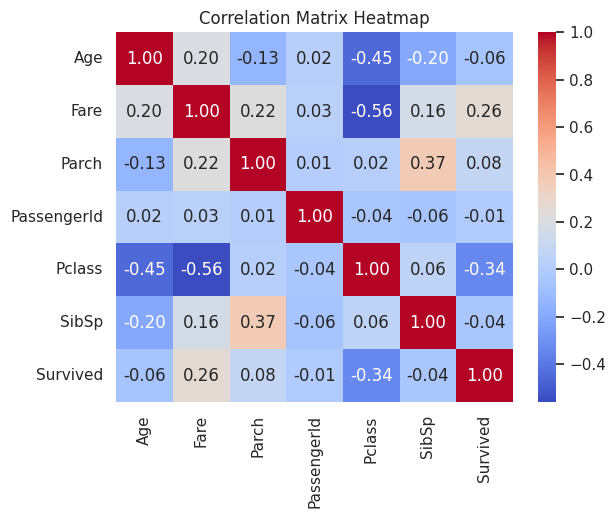

In [40]:
# prompt: df_all.select_dtypes(include=np.number).corr()를 heatmap으로 시각화해줘

sns.heatmap(df_all.select_dtypes(include=np.number).corr(),
            annot=True,
            cmap='coolwarm',
            fmt=".2f")

plt.title('Correlation Matrix Heatmap')

### **1.5 Target Distribution in Features**

#### **1.5.1 Continuous Features**
Both of the continuous features (`Age` and `Fare`) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

* Distribution of `Age` feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
* In distribution of `Fare` feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

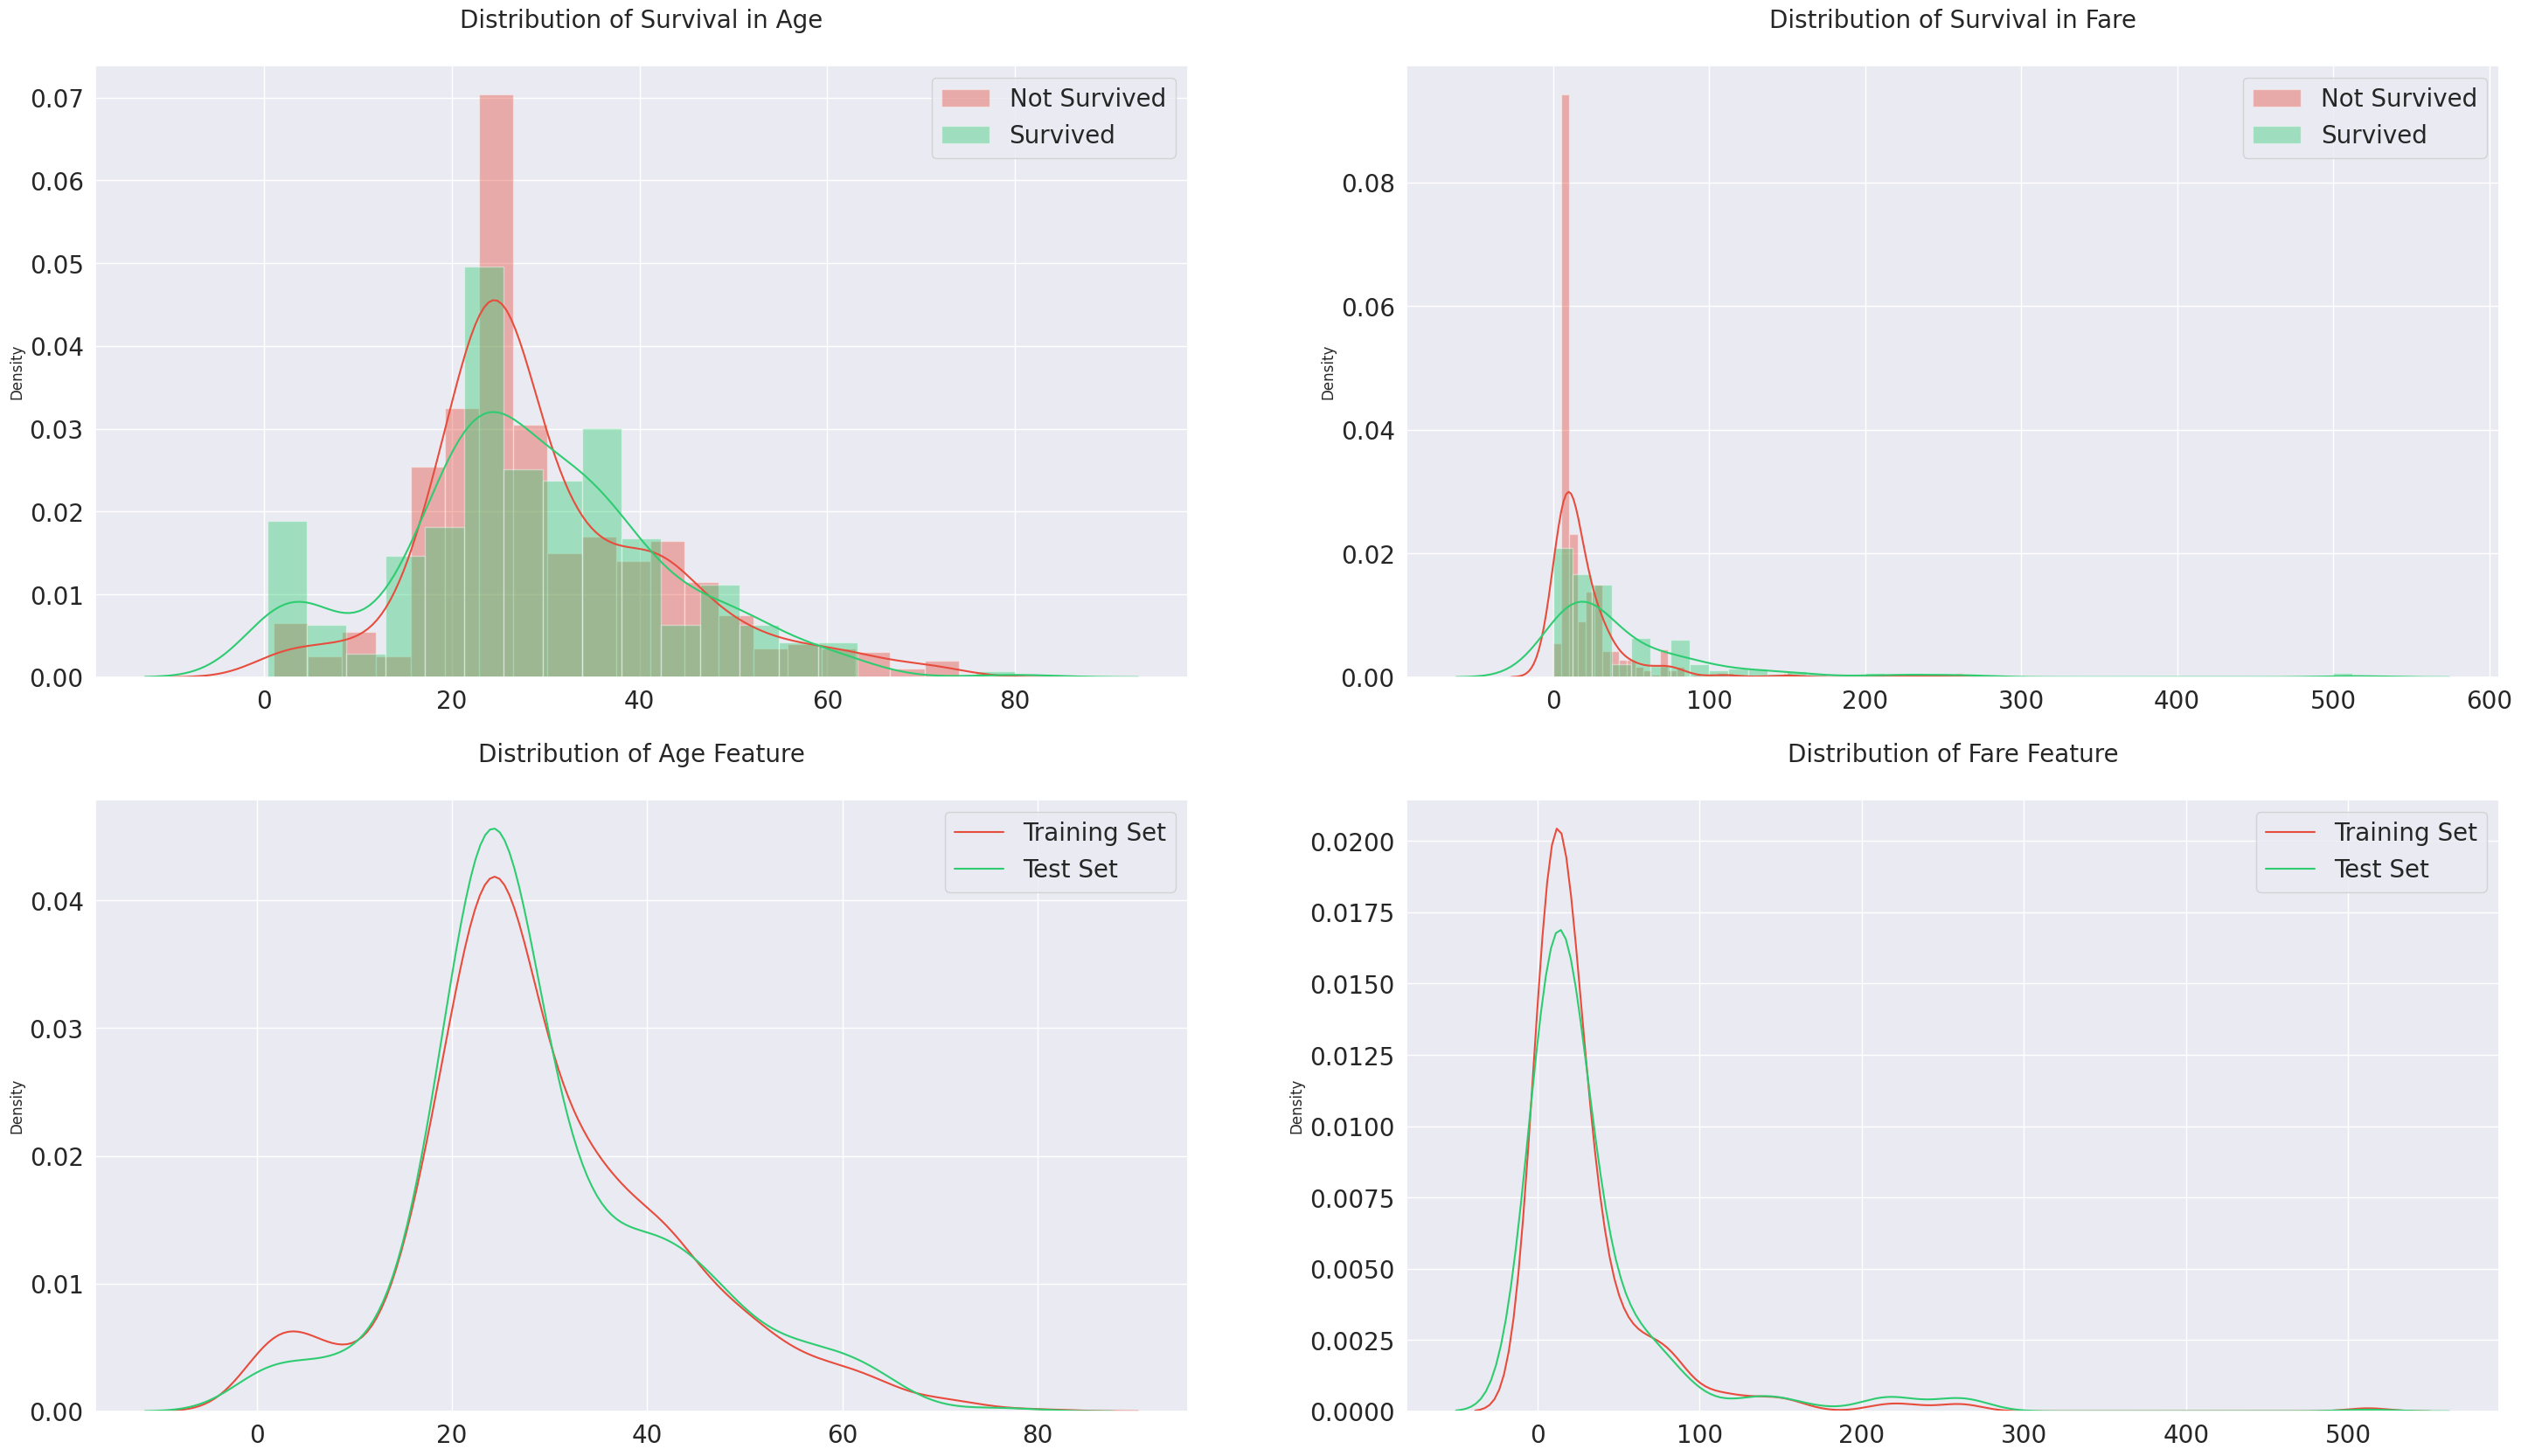

In [41]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])

    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])

    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')

    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)

    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)

plt.show()

#### **1.5.2 Categorical Features**
Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are `Pclass` and `Sex` because they have the most homogenous distributions.

* Passengers boarded from **Southampton** has a lower survival rate unlike other ports. More than half of the passengers boarded from **Cherbourg** had survived. This observation could be related to `Pclass` feature
* `Parch` and `SibSp` features show that passengers with only one family member has a higher survival rate

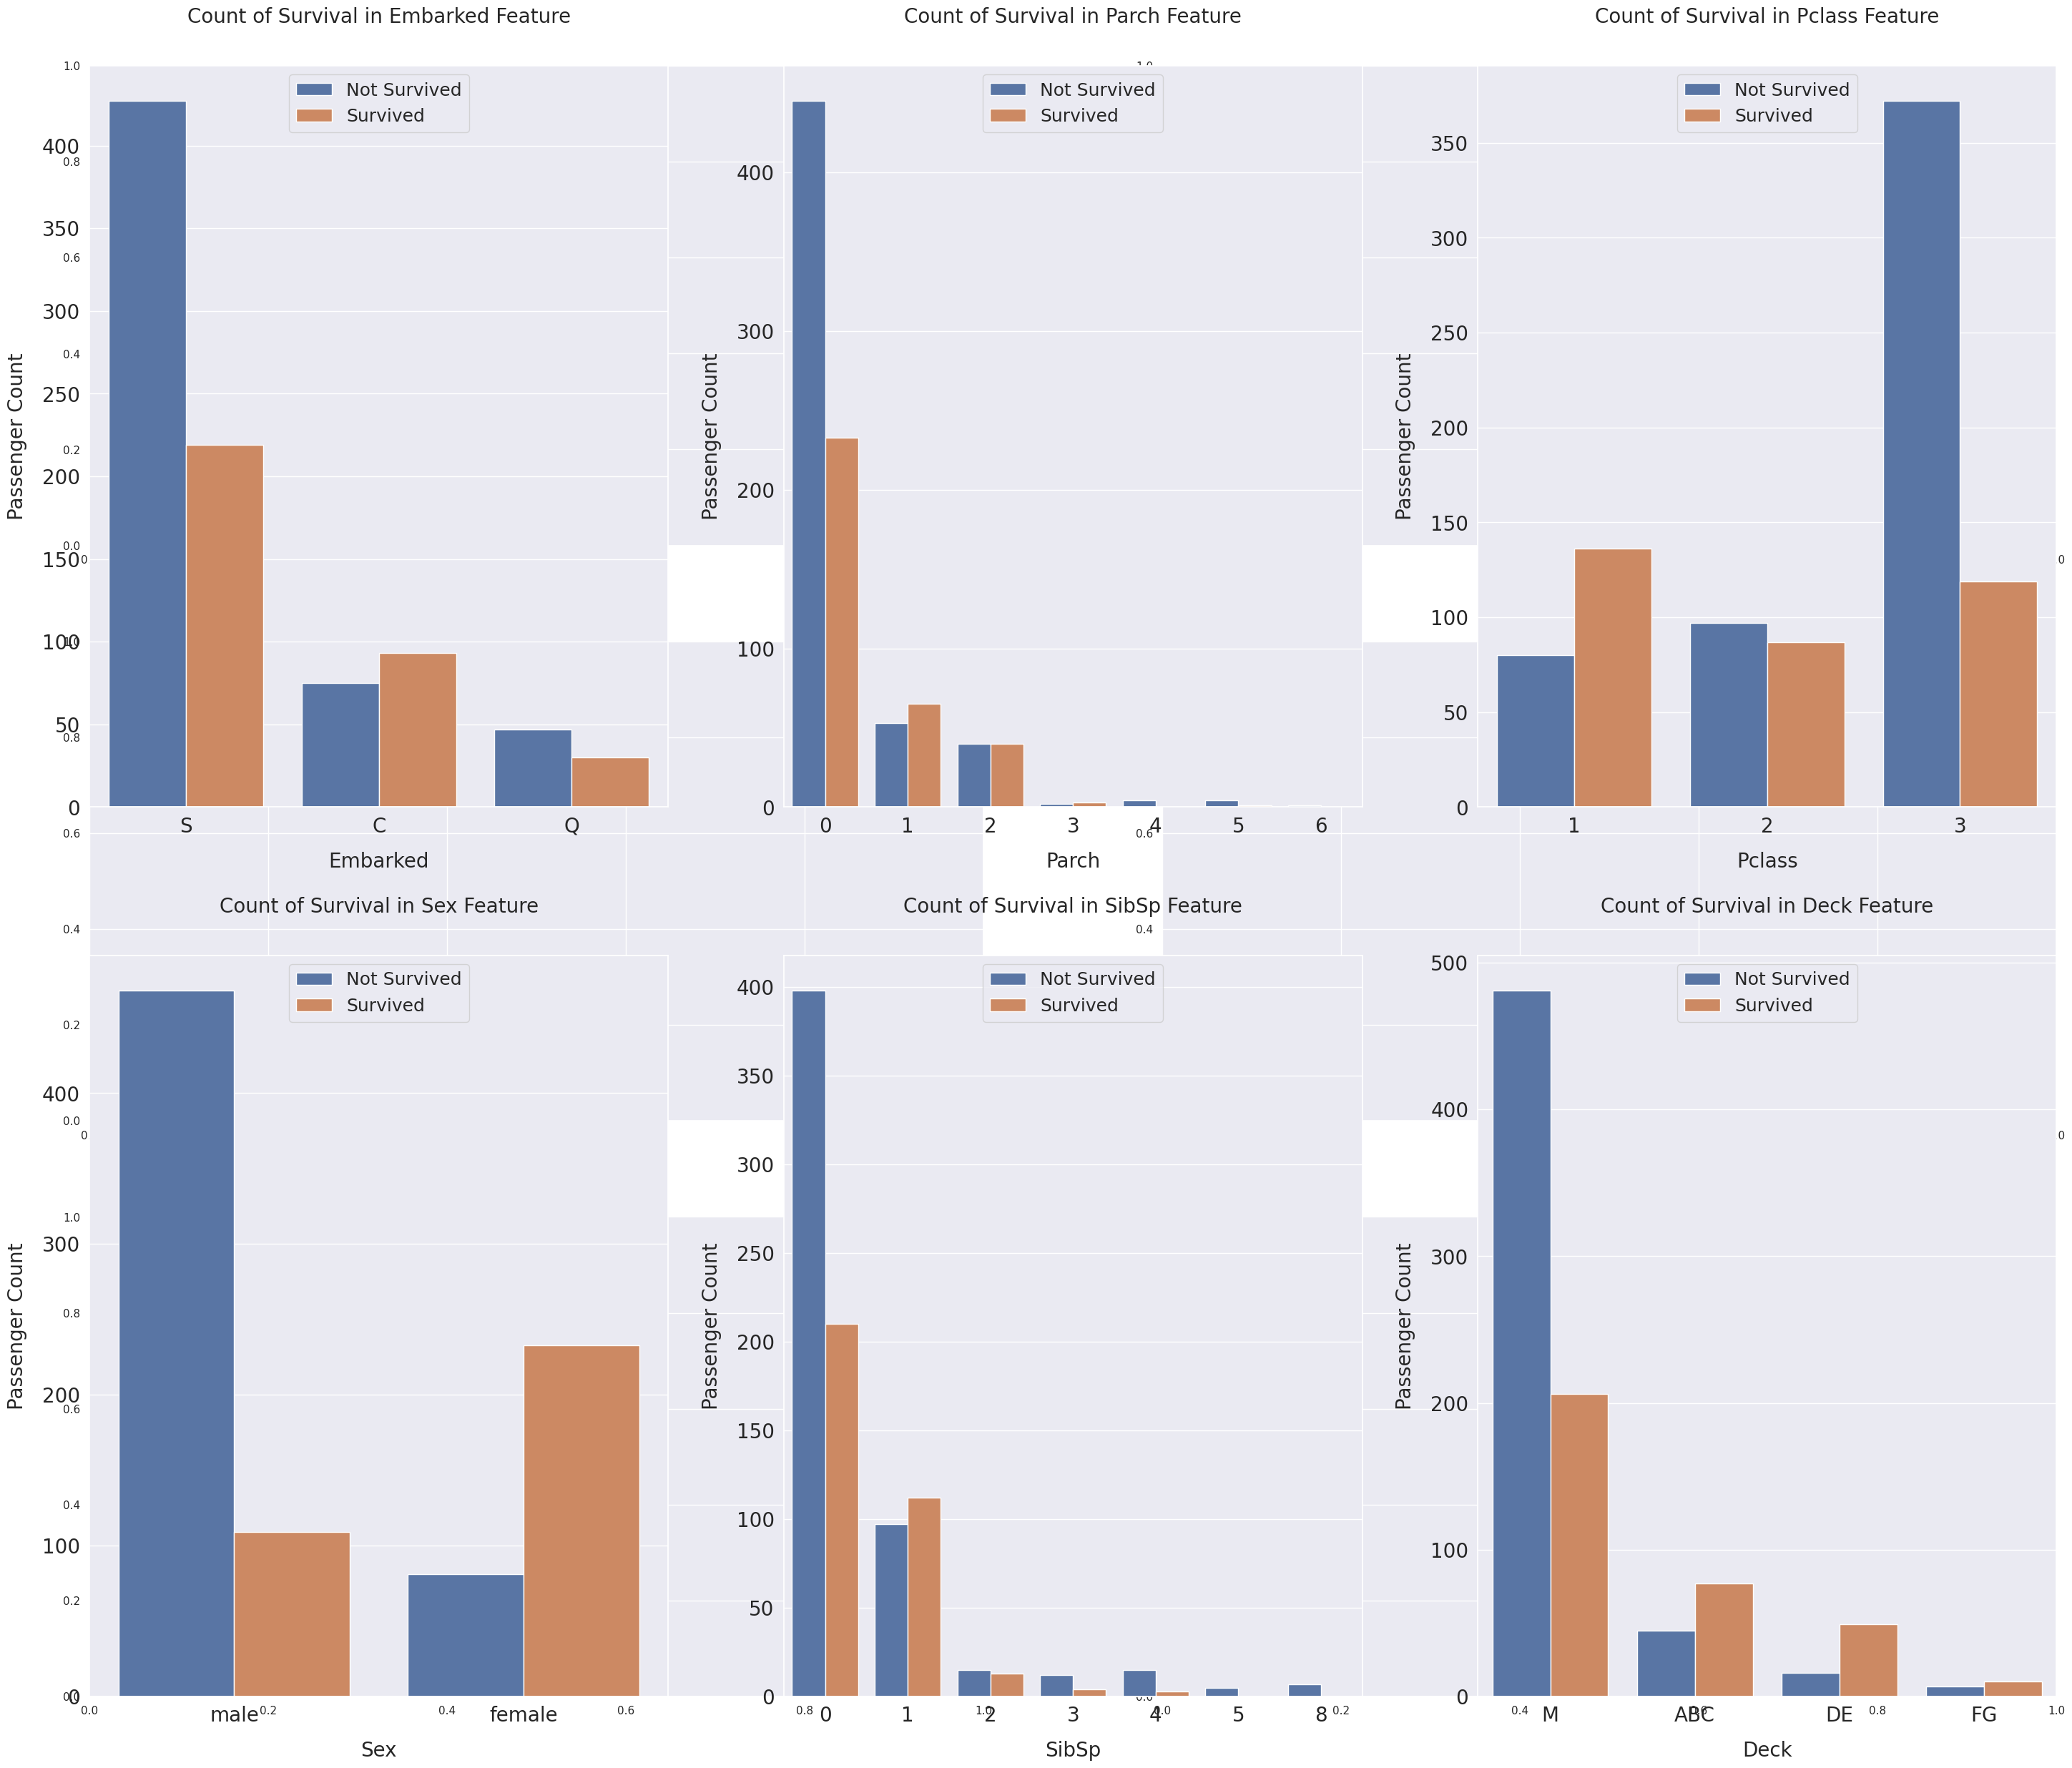

In [42]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)

    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### **1.6 Conclusion**
Most of the features are correlated with each other. This relationship can be used to create new features with feature transformation and feature interaction. Target encoding could be very useful as well because of the high correlations with `Survived` feature.

Split points and spikes are visible in continuous features. They can be captured easily with a decision tree model, but linear models may not be able to spot them.

Categorical features have very distinct distributions with different survival rates. Those features can be one-hot encoded. Some of those features may be combined with each other to make new features.

Created a new feature called `Deck` and dropped `Cabin` feature at the **Exploratory Data Analysis** part.

In [43]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [44]:
analyze_df(df_all)

,uniques,datatype,missing_ratio,top10_values
Age,99,float64,0.000000,"[80.0, 76.0, 74.0, 71.0, 71.0, 70.5, 70.0, 70...."
Deck,4,object,0.000000,"[M, ABC, DE, FG]"
Embarked,3,object,0.000000,"[S, C, Q]"
Fare,281,float64,0.000000,"[512.3292, 512.3292, 512.3292, 512.3292, 263.0..."
Name,1307,object,0.000000,"[Connolly, Miss. Kate, Kelly, Mr. James, Braun..."
Parch,8,int64,0.000000,"[9, 9, 6, 6, 5, 5, 5, 5, 5, 5]"
PassengerId,1309,int64,0.000000,"[1309, 1308, 1307, 1306, 1305, 1304, 1303, 130..."
Pclass,3,int64,0.000000,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
Sex,2,object,0.000000,"[male, female]"
SibSp,7,int64,0.000000,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 5]"


## **2. Feature Engineering**

### **2.1 Binning Continuous Features**

#### **2.1.1 Fare**
`Fare` feature is positively skewed and survival rate is extremely high on the right end. **13** quantile based bins are used for `Fare` feature. Even though the bins are too much, they provide decent amount of information gain. The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group **(15.742, 23.25]** in the middle with high survival rate that is captured in this process.

In [45]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)
df_all['Fare']

,Fare
0,"(-0.001, 7.25]"
1,"(56.496, 83.475]"
2,"(7.896, 8.05]"
3,"(34.075, 56.496]"
4,"(7.896, 8.05]"
...,...
1304,"(7.896, 8.05]"
1305,"(83.475, 512.329]"
1306,"(-0.001, 7.25]"
1307,"(7.896, 8.05]"


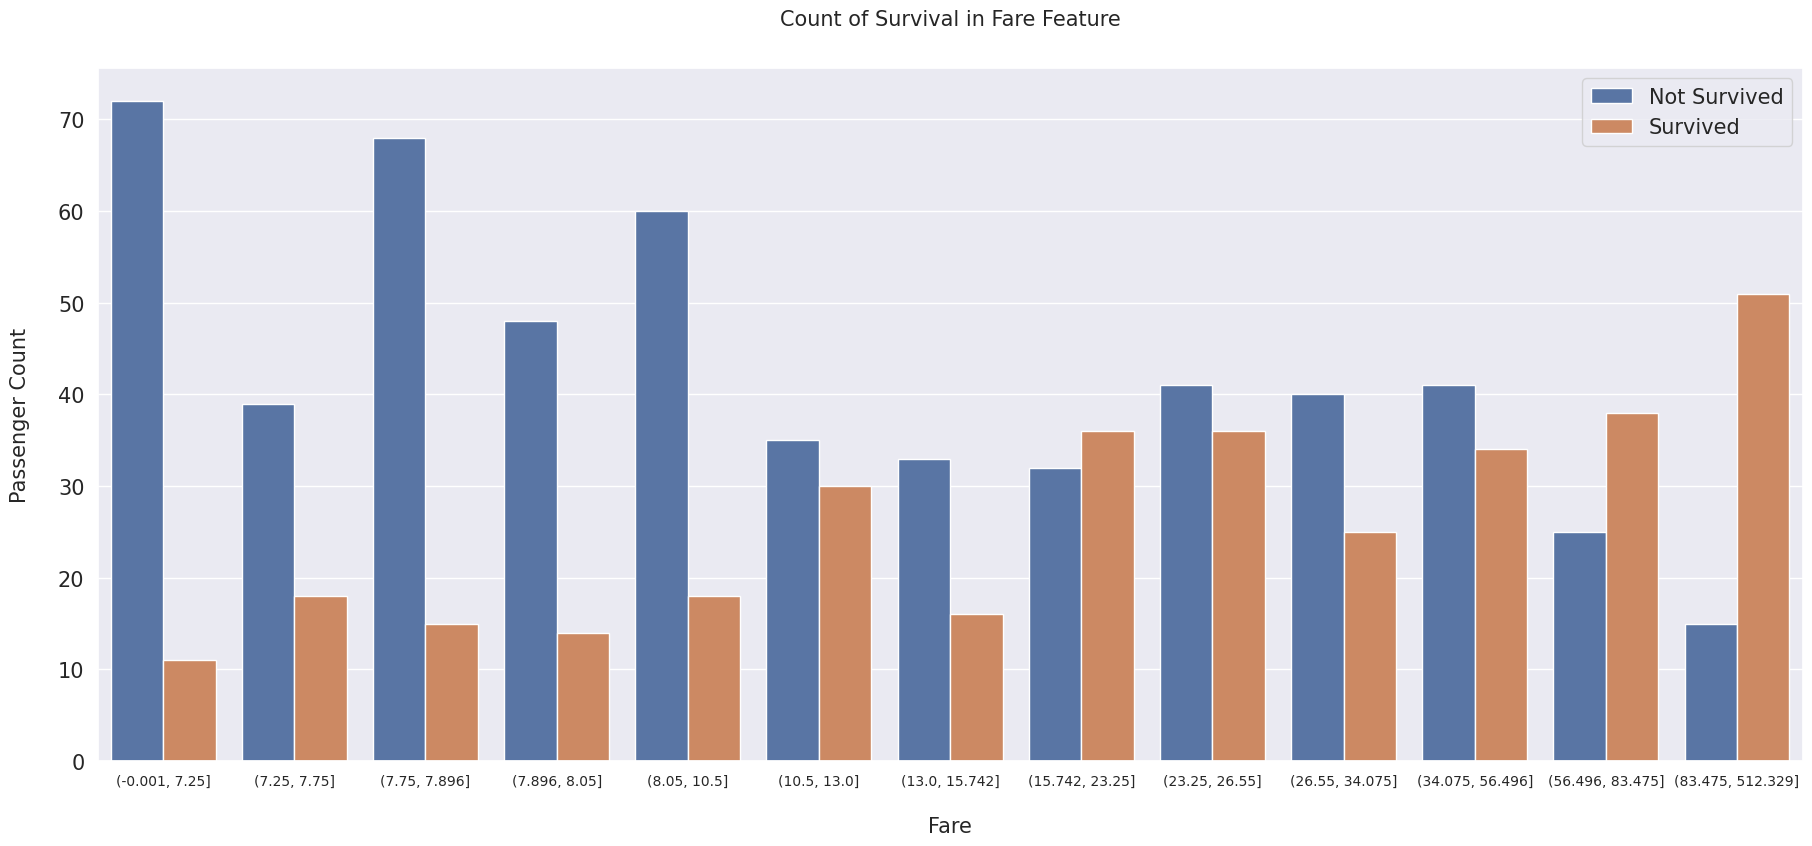

In [46]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

#### **2.1.2 Age**
`Age` feature has a normal distribution with some spikes and bumps and **10** quantile based bins are used for `Age`. The first bin has the highest survival rate and 4th bin has the lowest survival rate. Those were the biggest spikes in the distribution. There is also an unusual group **(34.0, 40.0]** with high survival rate that is captured in this process.

In [47]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

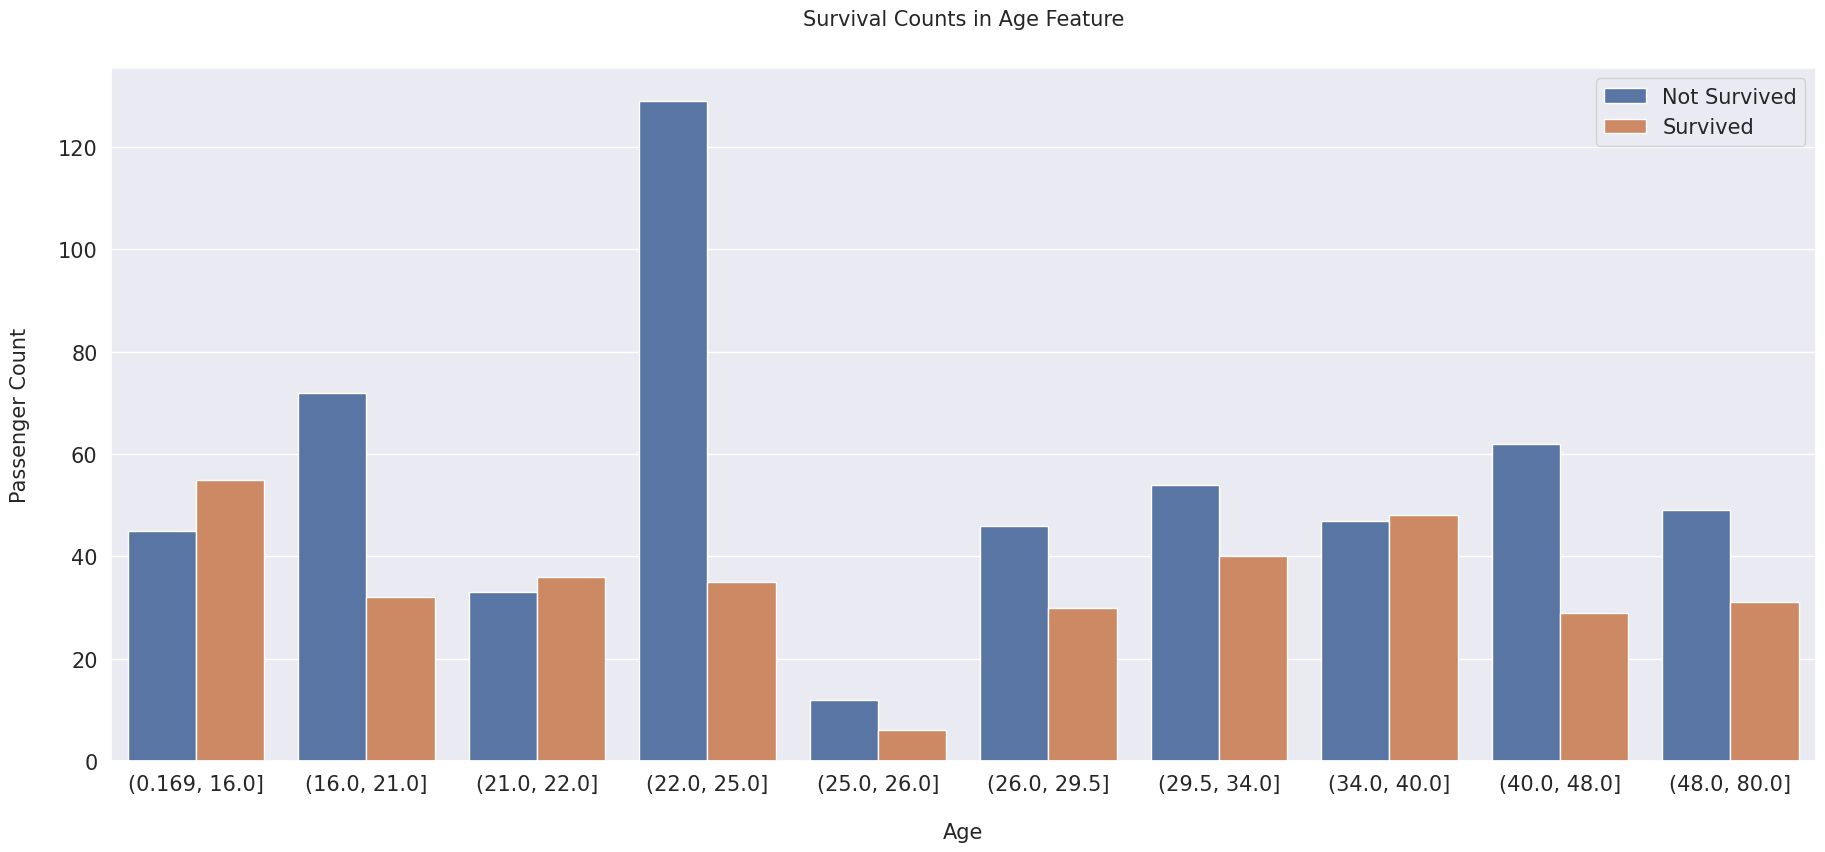

In [48]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### **2.2 Frequency Encoding**
`Family_Size` is created by adding `SibSp`, `Parch` and **1**. `SibSp` is the count of siblings and spouse, and `Parch` is the count of parents and children. Those columns are added in order to find the total size of families. Adding **1** at the end, is the current passenger. Graphs have clearly shown that family size is a predictor of survival because different values have different survival rates.
* Family Size with **1** are labeled as **Alone**
* Family Size with **2**, **3** and **4** are labeled as **Small**
* Family Size with **5** and **6** are labeled as **Medium**
* Family Size with **7**, **8** and **11** are labeled as **Large**

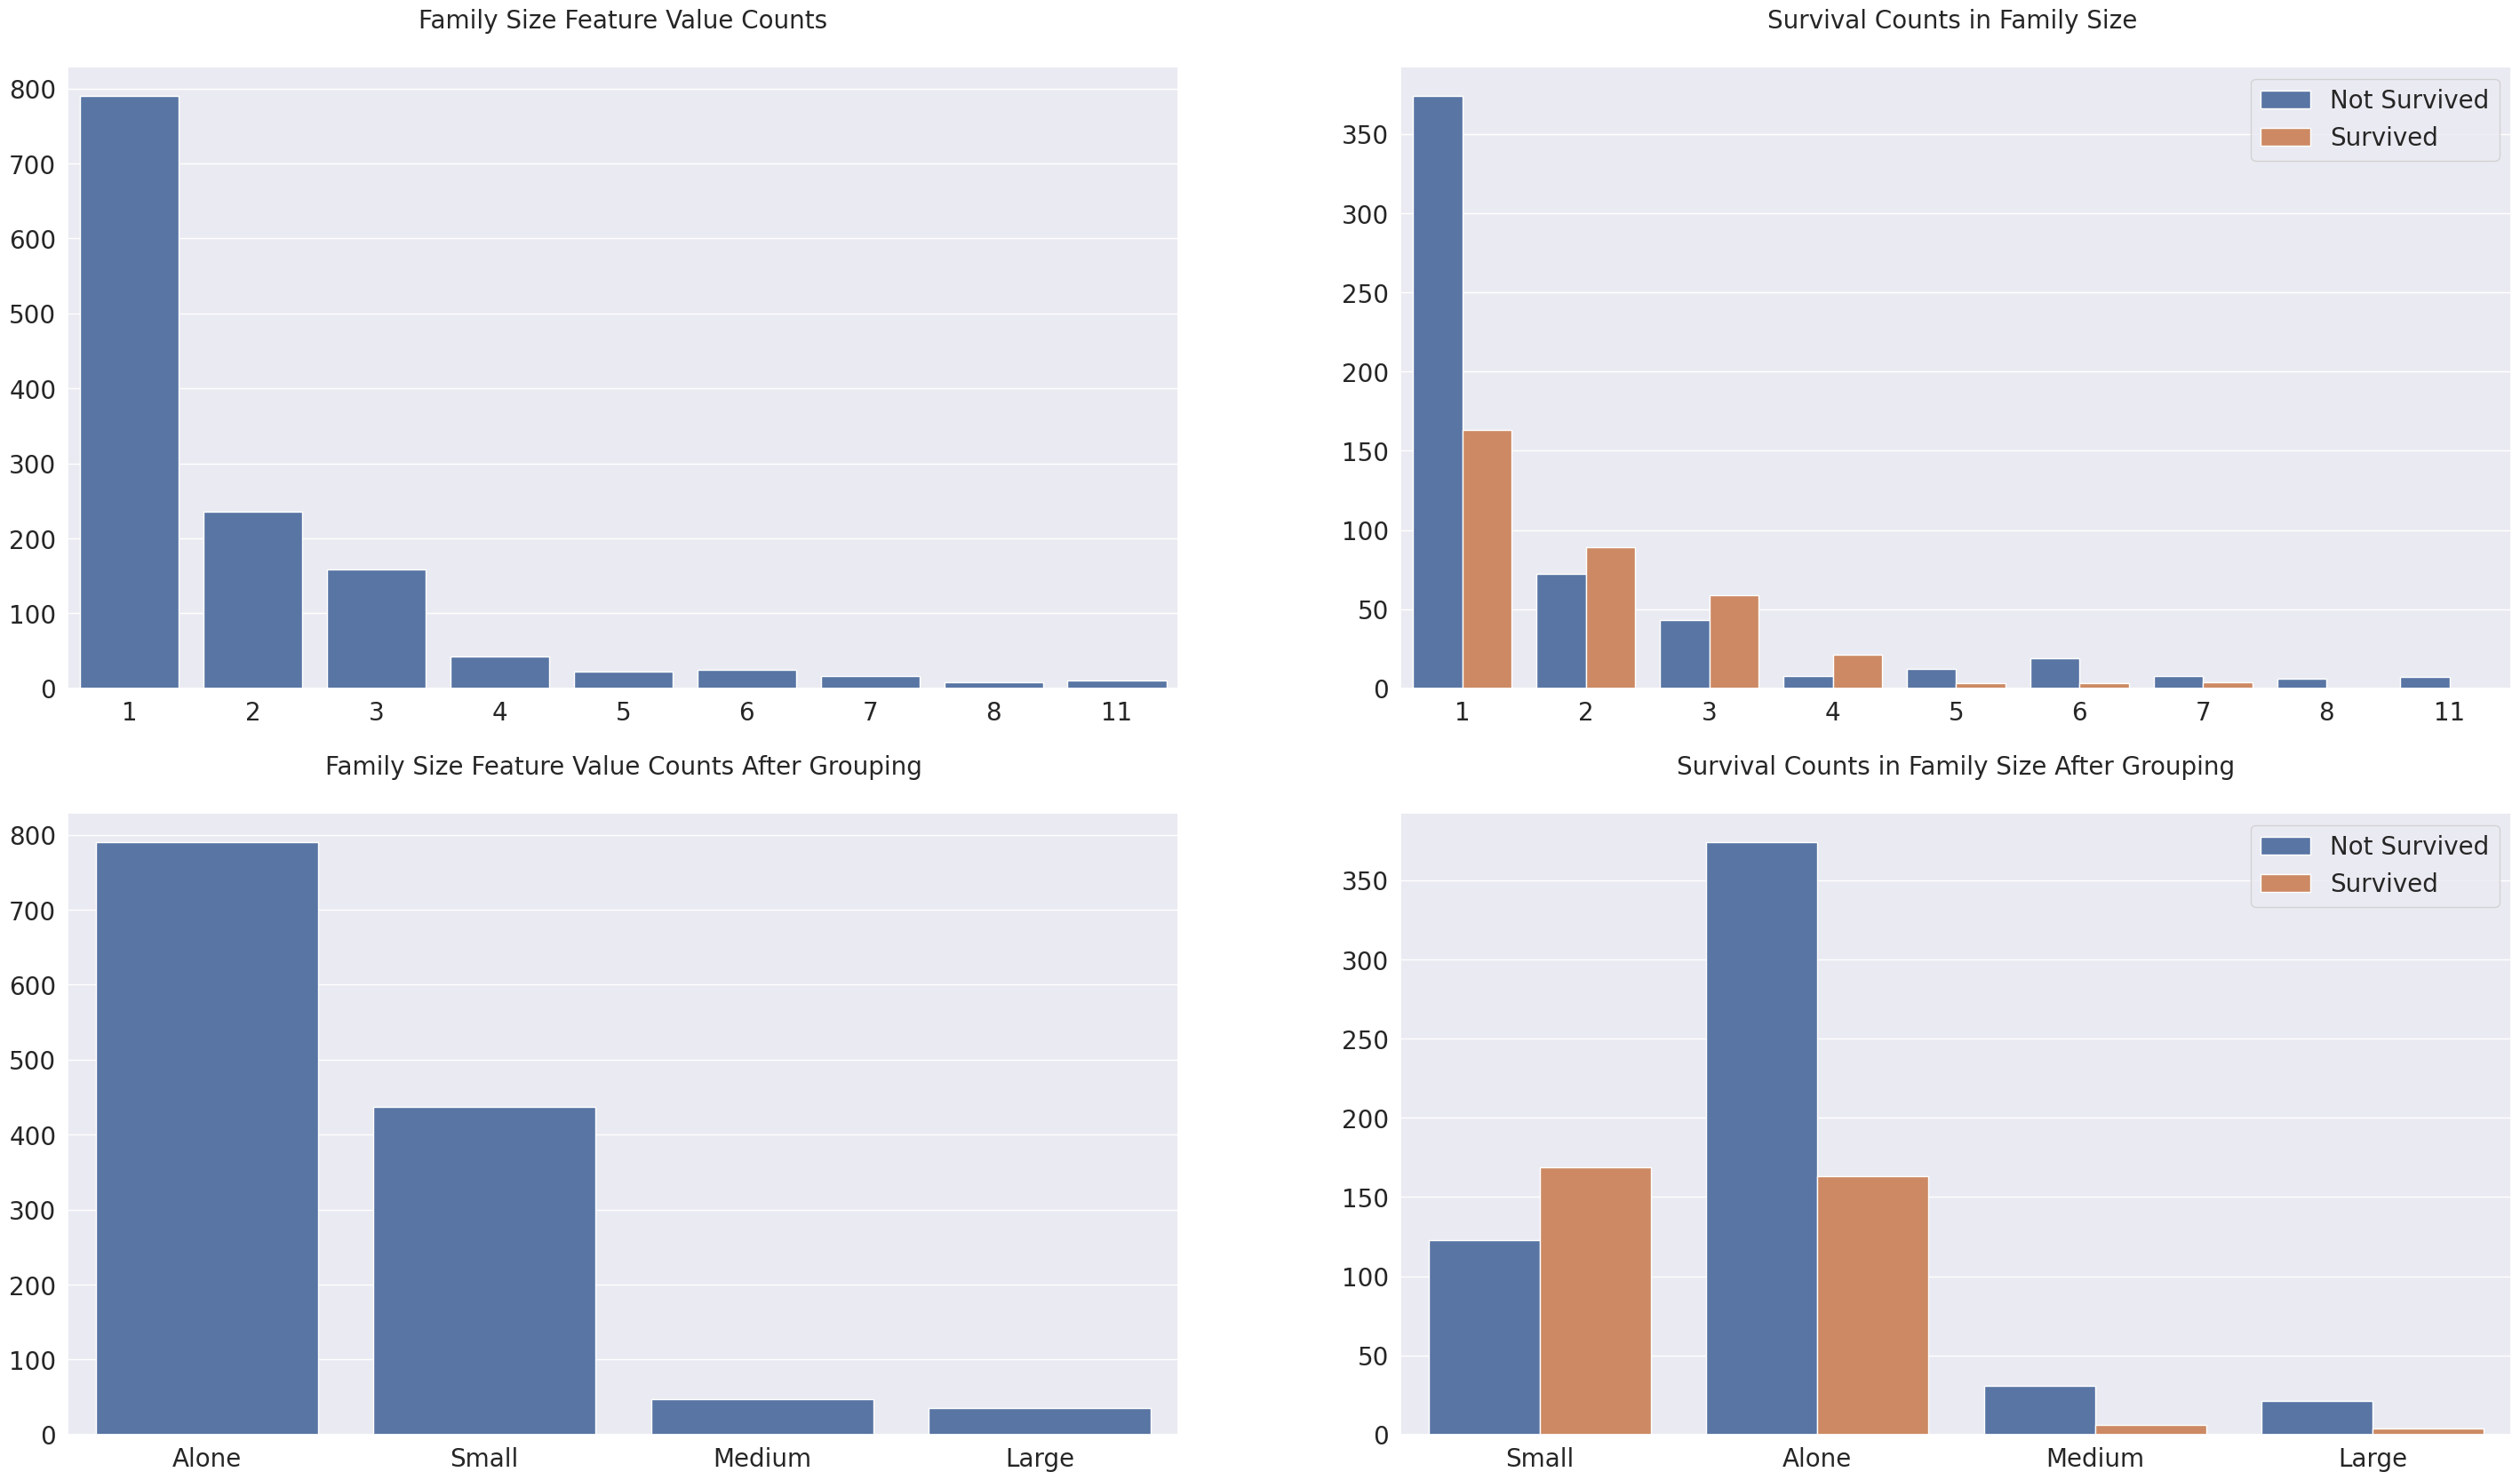

In [49]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

There are too many unique `Ticket` values to analyze, so grouping them up by their frequencies makes things easier.

**How is this feature different than `Family_Size`?** Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

**Why not grouping tickets by their prefixes?** If prefixes in `Ticket` feature has any meaning, then they are already captured in `Pclass` or `Embarked` features because that could be the only logical information which can be derived from the `Ticket` feature.

According to the graph below, groups with **2**,**3** and **4** members had a higher survival rate. Passengers who travel alone has the lowest survival rate. After **4** group members, survival rate decreases drastically. This pattern is very similar to `Family_Size` feature but there are minor differences. `Ticket_Frequency` values are not grouped like `Family_Size` because that would basically create the same feature with perfect correlation. This kind of feature wouldn't provide any additional information gain.

In [50]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')
df_all['Ticket_Frequency']

,Ticket_Frequency
0,1
1,2
2,1
3,2
4,1
...,...
1304,1
1305,3
1306,1
1307,1


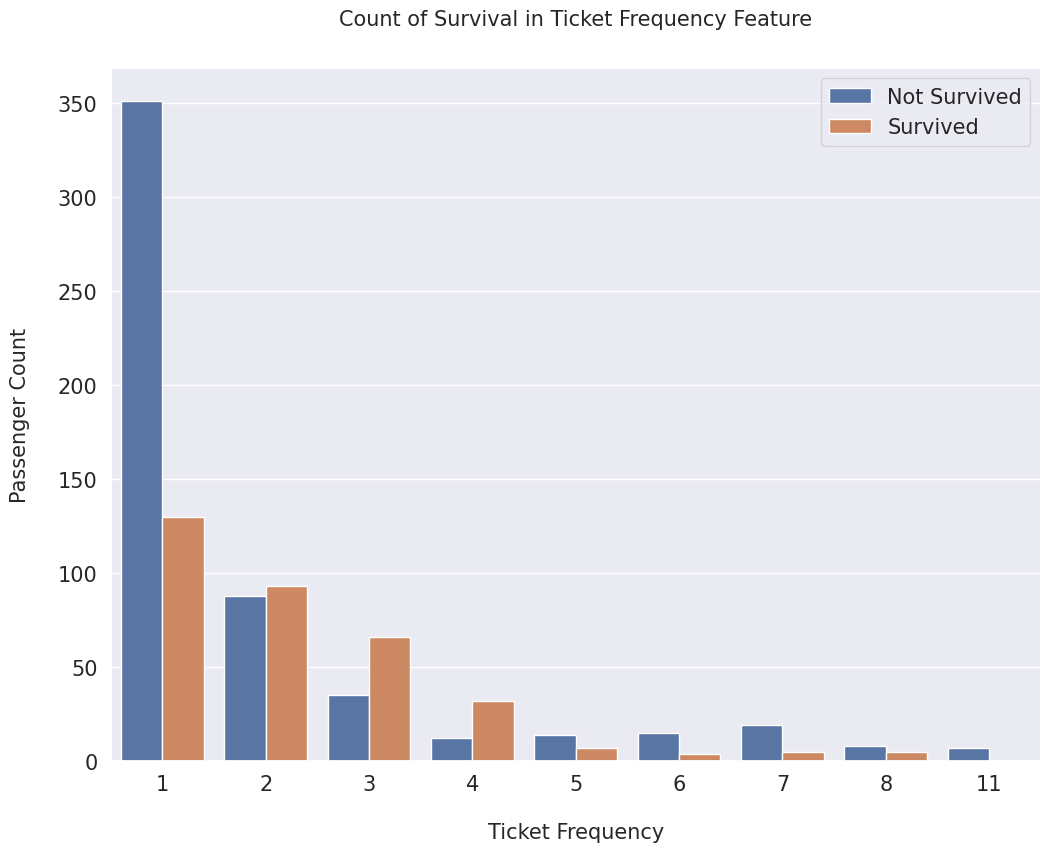

In [51]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### **2.3 Title & Is Married**
`Title` is created by extracting the prefix before `Name` feature. According to graph below, there are many titles that are occuring very few times. Some of those titles doesn't seem correct and they need to be replaced. **Miss**, **Mrs**, **Ms**, **Mlle**, **Lady**, **Mme**, **the Countess**, **Dona** titles are replaced with **Miss/Mrs/Ms** because all of them are female. Values like **Mlle**, **Mme** and **Dona** are actually the name of the passengers, but they are classified as titles because `Name` feature is split by comma. **Dr**, **Col**, **Major**, **Jonkheer**, **Capt**, **Sir**, **Don** and **Rev** titles are replaced with **Dr/Military/Noble/Clergy** because those passengers have similar characteristics. **Master** is a unique title. It is given to male passengers below age **26**. They have the highest survival rate among all males.

`Is_Married` is a binary feature based on the **Mrs** title. **Mrs** title has the highest survival rate among other female titles. This title needs to be a feature because all female titles are grouped with each other.

In [52]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

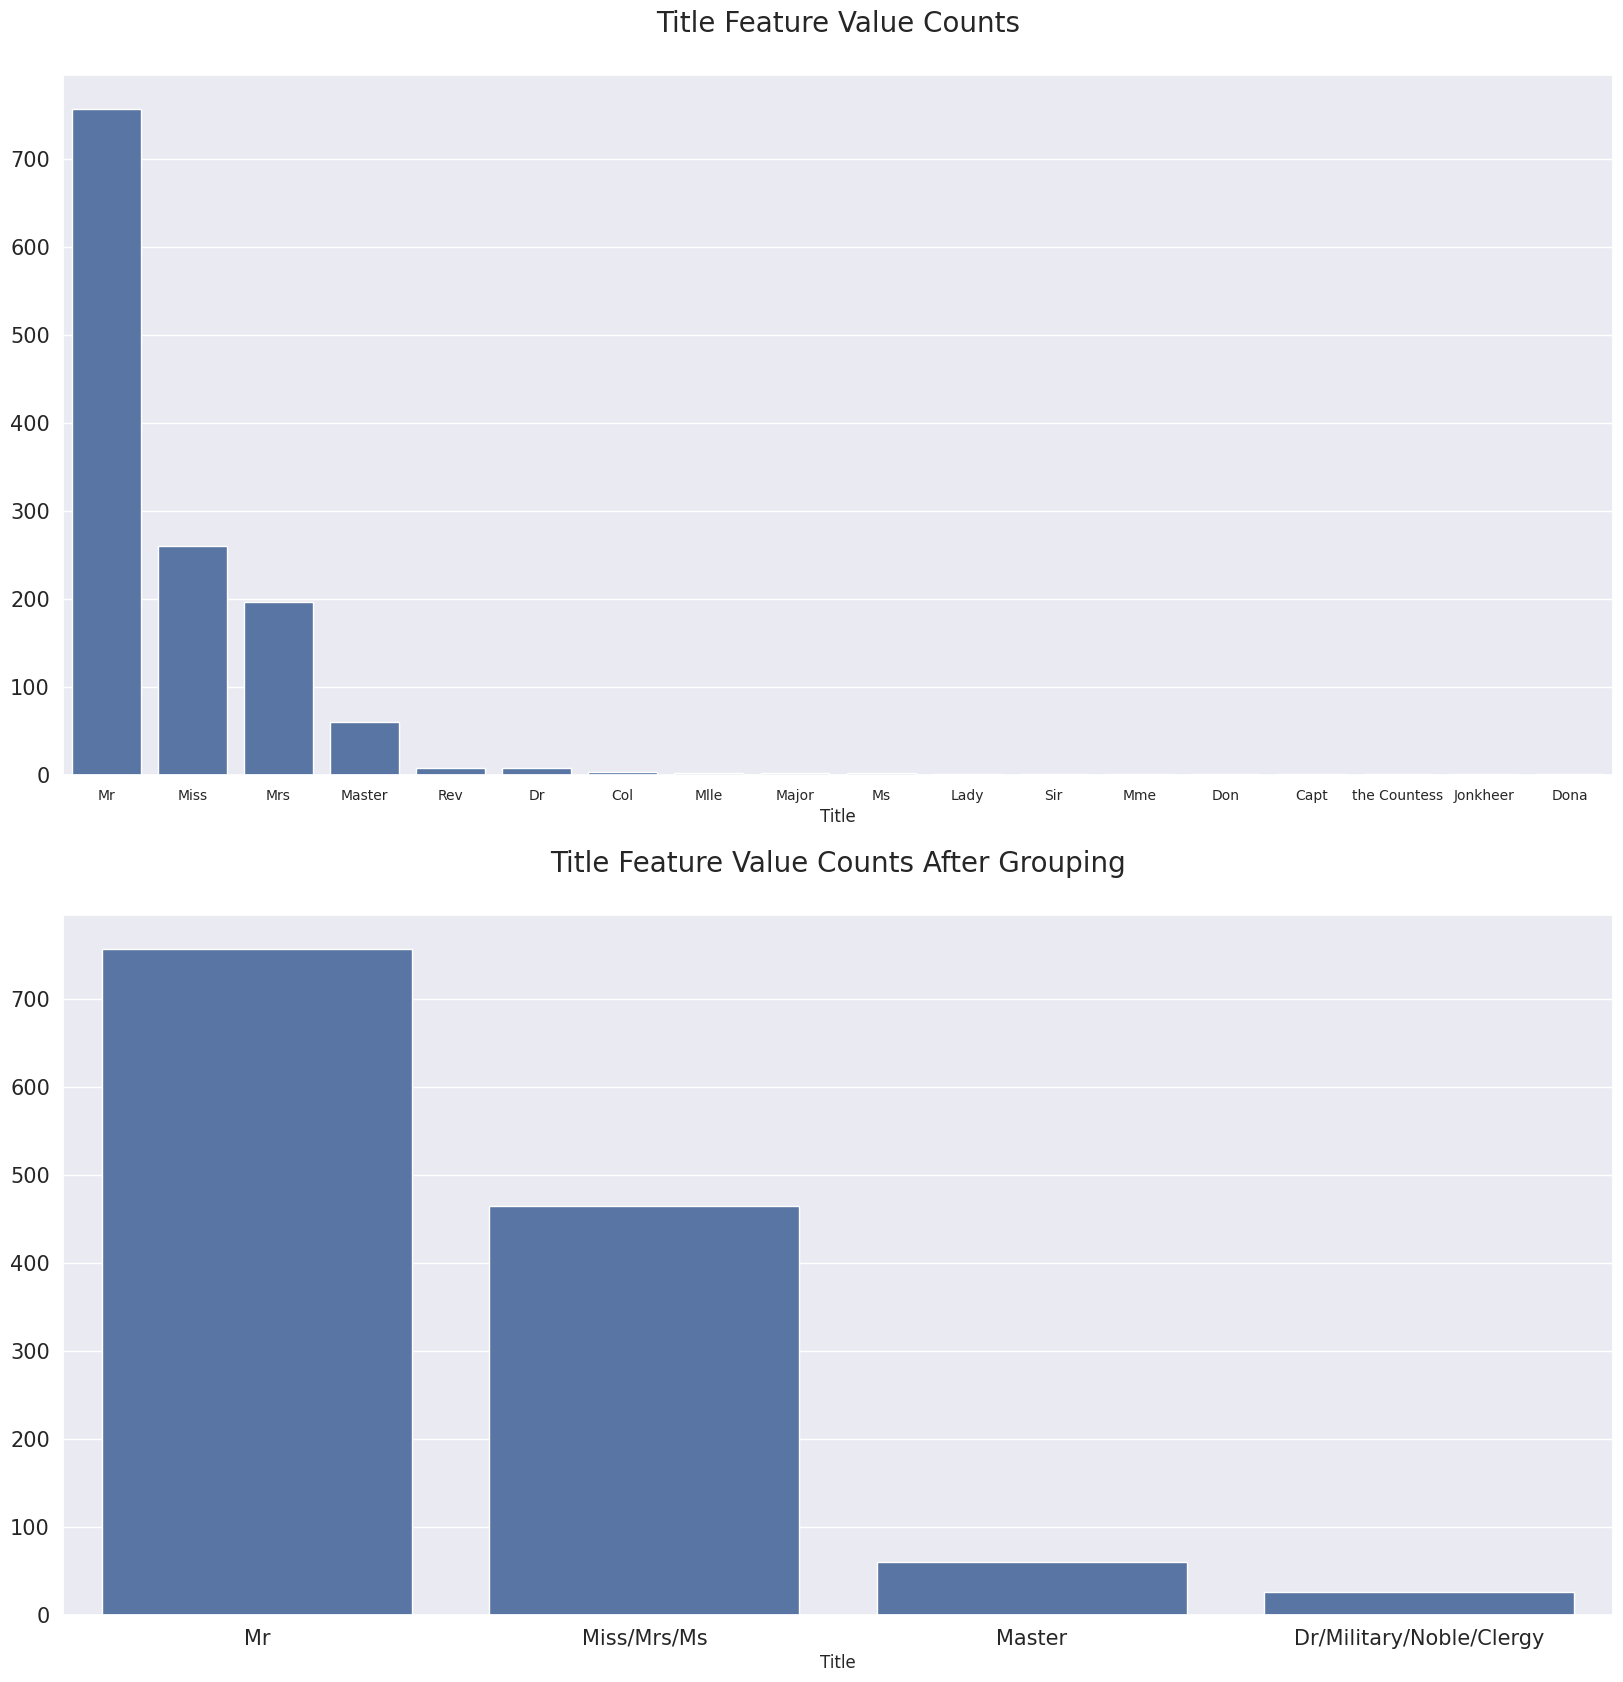

In [53]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### **2.4 Target Encoding**
`extract_surname` function is used for extracting surnames of passengers from the `Name` feature. `Family` feature is created with the extracted surname. This is necessary for grouping passengers in the same family.

In [54]:
def extract_surname(data):

    families = []

    for i in range(len(data)):
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name

        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]

        for c in string.punctuation:
            family = family.replace(c, '').strip()

        families.append(family)

    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

`Family_Survival_Rate` is calculated from families in training set since there is no `Survived` feature in test set. A list of family names that are occuring in both training and test set (`non_unique_families`), is created. The survival rate is calculated for families with more than 1 members in that list, and stored in `Family_Survival_Rate` feature.

An extra binary feature `Family_Survival_Rate_NA` is created for families that are unique to the test set. This feature is also necessary because there is no way to calculate those families' survival rate. This feature implies that family survival rate is not applicable to those passengers because there is no way to retrieve their survival rate.

`Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are also created with the same method. `Ticket_Survival_Rate` and `Family_Survival_Rate` are averaged and become `Survival_Rate`, and `Ticket_Survival_Rate_NA` and `Family_Survival_Rate_NA` are also averaged and become `Survival_Rate_NA`.

In [55]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2

KeyError: 'Ticket_Survival_Rate'

### **2.5 Feature Transformation**

#### **2.5.1 Label Encoding Non-Numerical Features**
`Embarked`, `Sex`, `Deck` , `Title` and `Family_Size_Grouped` are object type, and `Age` and `Fare` features are category type. They are converted to numerical type with `LabelEncoder`. `LabelEncoder` basically labels the classes from **0** to **n**. This process is necessary for models to learn from those features.

In [56]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:
        df[feature] = LabelEncoder().fit_transform(df[feature])

#### **2.5.2 One-Hot Encoding the Categorical Features**
The categorical features (`Pclass`, `Sex`, `Deck`, `Embarked`, `Title`) are converted to one-hot encoded features with `OneHotEncoder`. `Age` and `Fare` features are not converted because they are ordinal unlike the previous ones.

In [57]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [58]:
df_train

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,2,3,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,0,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,3,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,7,0,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,7,3,2,3,"Allen, Mr. William Henry",0,5,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,5,3,2,5,"Montvila, Rev. Juozas",0,887,2,1,0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
887,1,0,2,9,"Graham, Miss. Margaret Edith",0,888,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,2,3,2,8,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
889,4,0,0,9,"Behr, Mr. Karl Howell",0,890,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### **2.6 Conclusion**
`Age` and `Fare` features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features. `Family_Size` is created by adding `Parch` and `SibSp` features and **1**. `Ticket_Frequency` is created by counting the occurence of `Ticket` values.

`Name` feature is very useful. First, `Title` and `Is_Married` features are created from the title prefix in the names. Second, `Family_Survival_Rate` and `Family_Survival_Rate_NA`  features are created by target encoding the surname of the passengers. `Ticket_Survival_Rate` is created by target encoding the `Ticket` feature. `Survival_Rate` feature is created by averaging the `Family_Survival_Rate` and `Ticket_Survival_Rate` features.

Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded. Created **5** new features (`Family_Size`, `Title`, `Is_Married`, `Survival_Rate` and `Survival_Rate_NA`) and dropped the useless features after encoding.

In [59]:
df_all = concat_df(df_train, df_test)
df_all

,Age,Deck,Deck_1,Deck_2,Deck_3,Deck_4,Embarked,Embarked_1,Embarked_2,Embarked_3,...,Sex_2,SibSp,Survived,Ticket,Ticket_Frequency,Title,Title_1,Title_2,Title_3,Title_4
0,2,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,1.0,1,0.0,A/5 21171,1,3,0.0,0.0,0.0,1.0
1,7,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,...,0.0,1,1.0,PC 17599,2,2,0.0,0.0,1.0,0.0
2,4,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,0.0,0,1.0,STON/O2. 3101282,1,2,0.0,0.0,1.0,0.0
3,7,0,1.0,0.0,0.0,0.0,2,0.0,0.0,1.0,...,0.0,1,1.0,113803,2,2,0.0,0.0,1.0,0.0
4,7,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,1.0,0,0.0,373450,1,3,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,1.0,0,NaN,A.5. 3236,1,3,0.0,0.0,0.0,1.0
1305,7,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,...,0.0,0,NaN,PC 17758,3,2,0.0,0.0,1.0,0.0
1306,7,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,1.0,0,NaN,SOTON/O.Q. 3101262,1,3,0.0,0.0,0.0,1.0
1307,3,3,0.0,0.0,0.0,1.0,2,0.0,0.0,1.0,...,1.0,0,NaN,359309,1,3,0.0,0.0,0.0,1.0


## **3. Model**
# <font color='red'> **Pycaret으로 Low Code**

In [6]:
df_train = pd.read_csv(train_csv_path)
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
# prompt: pycaret으로 예측해줘

# !pip install pycaret

import pandas as pd
from pycaret.classification import *

# Assuming 'df_train' is your training DataFrame with a 'Survived' target column
# and other features already prepared as shown in your provided code.

# Initialize the setup
clf = setup(data = df_train, target = 'Survived', session_id=123)

,Description,Value
0,Session id,123
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 12)"
4,Transformed data shape,"(891, 14)"
5,Transformed train set shape,"(623, 14)"
6,Transformed test set shape,"(268, 14)"
7,Numeric features,6
8,Categorical features,5
9,Rows with missing values,79.5%


In [8]:
# Compare different models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8040,0.8684,0.6739,0.7855,0.7204,0.5724,0.5799,1.4570
ridge,Ridge Classifier,0.7528,0.8647,0.4522,0.8257,0.5793,0.4273,0.4679,0.2170
et,Extra Trees Classifier,0.7400,0.7837,0.4774,0.7654,0.5815,0.4088,0.4356,0.4020
nb,Naive Bayes,0.6709,0.7925,0.1761,0.8582,0.2816,0.1808,0.2747,0.2730
knn,K Neighbors Classifier,0.6275,0.5906,0.3690,0.5175,0.4255,0.1654,0.1713,0.1990
lda,Linear Discriminant Analysis,0.6260,0.5382,0.0348,0.0800,0.0485,0.0335,0.0389,0.1070
dt,Decision Tree Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2010
rf,Random Forest Classifier,0.6164,0.7890,0.0000,0.0000,0.0000,0.0000,0.0000,0.2640
qda,Quadratic Discriminant Analysis,0.6164,0.5029,0.0000,0.0000,0.0000,0.0000,0.0000,0.1100
ada,Ada Boost Classifier,0.6164,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1100


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [9]:
# Tune the best model
tuned_best_model = tune_model(best_model)
tuned_best_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8611,0.7917,0.8261,0.8085,0.6947,0.6951
1,0.8095,0.8162,0.7083,0.7727,0.7391,0.5896,0.5910
2,0.9365,0.9658,0.8750,0.9545,0.9130,0.8632,0.8652
3,0.8548,0.9030,0.7826,0.8182,0.8000,0.6862,0.6866
4,0.7258,0.8311,0.5000,0.7059,0.5854,0.3893,0.4023
5,0.7903,0.8300,0.7500,0.7200,0.7347,0.5615,0.5618
6,0.8065,0.8476,0.5833,0.8750,0.7000,0.5654,0.5908
7,0.8226,0.8706,0.7083,0.8095,0.7556,0.6173,0.6207
8,0.7581,0.8487,0.5833,0.7368,0.6512,0.4698,0.4773


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


LogisticRegression(C=8.866, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
tuned_best_model.get_params()

{'C': 8.866,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [11]:
# Evaluate the model
evaluate_model(tuned_best_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [12]:

# Predict on new data (replace df_test with your test data)
predictions = predict_model(tuned_best_model, data=df_test)

# Print predictions
predictions

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prediction_label,prediction_score
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.829200,NaN,Q,0,0.9356
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.000000,NaN,S,0,0.6079
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.687500,NaN,Q,0,0.8576
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.662500,NaN,S,0,0.8249
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.287500,NaN,S,1,0.5145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.050000,NaN,S,0,0.8350
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900002,C105,C,1,0.5356
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250000,NaN,S,0,0.8625
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050000,NaN,S,0,0.8350
